<a href="https://colab.research.google.com/github/arnavsinghal09/GSoC-QMAML/blob/main/PCA%20as%20feature%20extactor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install h5py --quiet
!pip -q install "pennylane>=0.42" "pennylane-lightning>=0.42"
# keep thread usage sane on Colab CPU
import os
import torch
os.environ["OMP_NUM_THREADS"] = "2"
torch.set_num_threads(2)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 103.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 136.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 16.6 MB/s eta 0:00:00


In [ ]:
import h5py
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pennylane as qml
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Any
from dataclasses import dataclass, field
from sklearn.metrics import (accuracy_score,precision_score, recall_score, f1_score, classification_report, confusion_matrix)
from sklearn.decomposition import IncrementalPCA, PCA
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#  Cell 2: Config
@dataclass
class Config:
    # algo toggles
    Q_MAML_USE: bool = True
    LEARNER_HIDDEN: int = 256
    FREEZE_CNN_DURING_META: bool = True

    # data / tasking
    SAMPLES: int = 50000
    META_TASK_TYPE: List[str] = field(default_factory=lambda: ['pt', 'm0'])
    META_BIN_COUNT: int = 4
    SUPPORT_SIZE: int = 8
    QUERY_SIZE: int = 8
    MAX_META_TASKS: int = 48

    # model sizes
    NUM_QUBITS: int = 4
    Q_DEPTH: int = 2
    ENCODING_SCHEME: str = 'angle'
    CNN_OUTPUT_DIM: int = 512
    USE_PRETRAINED_CNN: bool = True

    # training
    USE_ANALYTIC_GRADIENTS: bool = True
    INNER_STEPS: int = 12
    INNER_LR: float = 0.02
    OUTER_LR: float = 0.05
    EPOCHS: int = 15
    BATCH_SIZE: int = 24
    EVAL_METRICS: bool = True
    SAVE_BEST_MODEL: bool = True

    # io
    PRETRAIN_QMAML: bool = True
    USE_QMAML_PRETRAINED_INIT: bool = True
    QMAML_INIT_TAG: str = "qmaml_init"
    CHECKPOINT_DIR: str = '/content/drive/MyDrive/quark-gluon-checkpoints'

config = Config()
os.makedirs(config.CHECKPOINT_DIR, exist_ok=True)


In [ ]:
#total L2 grad norm for a list of parameter groups
def _total_grad_norm(*param_groups) -> float:
    sq = 0.0
    for group in param_groups:
        for p in group:
            if (p.grad is not None) and torch.isfinite(p.grad).all():
                sq += float(p.grad.detach().norm(2).item() ** 2)
    return sq ** 0.5


In [ ]:
# --- Cell 3: Dataset Loading ---
class JetDataset(Dataset):
    """Custom Dataset for loading jet images, labels, and additional features."""
    def __init__(self, X: np.ndarray, y: np.ndarray, pt: np.ndarray = None, m0: np.ndarray = None):
        self.X = X
        self.y = y
        self.pt = pt
        self.m0 = m0

    def __len__(self) -> int:
        return len(self.y)

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, int]:
        return self.X[idx], self.y[idx]

def load_datasets(config: Config) -> Tuple[Dataset, Dataset]:
    """Load and return separate train and test datasets."""
    # Paths to datasets
    train_path = '/content/drive/MyDrive/quark-gluon-dataset/quark-gluon_train-set_n793900.hdf5'
    test1_path = '/content/drive/MyDrive/quark-gluon-dataset/quark-gluon_test-set_n139306.hdf5'

    with h5py.File(train_path, 'r') as f:
        X_train = f['X_jets'][:config.SAMPLES]
        y_train = f['y'][:config.SAMPLES]
        pt_train = f['pt'][:config.SAMPLES]
        m0_train = f['m0'][:config.SAMPLES]

    with h5py.File(test1_path, 'r') as f:
        X_test = f['X_jets'][:config.SAMPLES]
        y_test = f['y'][:config.SAMPLES]
        pt_test = f['pt'][:config.SAMPLES]
        m0_test = f['m0'][:config.SAMPLES]

    train_dataset = JetDataset(X_train, y_train, pt_train, m0_train)
    test_dataset = JetDataset(X_test, y_test, pt_test, m0_test)

    return train_dataset, test_dataset

# Load train and test datasets
train_dataset, test_dataset = load_datasets(config)


In [ ]:
# --- Cell 4: Meta-Task Generation ---
def generate_meta_tasks(
    dataset: Dataset,
    meta_task_types: List[str],
    bin_count: int,
    support_size: int,
    query_size: int,
    num_tasks_per_bin: int = 3,
    max_tasks: int = 40,
    seed: int = 42,
) -> List[Dict[str, Any]]:
    """
    Builds meta-tasks without duplicating the entire dataset in memory.
    Ensures balanced classes and disjoint support/query within each task.
    """
    rng = np.random.default_rng(seed)

    X = dataset.X                 # shape: (N, H, W, C)
    y = dataset.y                 # shape: (N,)

    assert support_size % 2 == 0 and query_size % 2 == 0, \
        "support_size and query_size must be even for class-balanced splits."

    half_s = support_size // 2
    half_q = query_size // 2

    meta_tasks: List[Dict[str, Any]] = []
    total_generated = 0

    for feature_type in meta_task_types:
        feature = getattr(dataset, feature_type)    # dataset.pt or dataset.m0

        fmin, fmax = float(np.min(feature)), float(np.max(feature))
        if not np.isfinite([fmin, fmax]).all() or fmin == fmax:
            continue
        bins = np.linspace(fmin, fmax, bin_count + 1, dtype=np.float64)

        for b in range(bin_count):
            lo, hi = bins[b], bins[b + 1]
            idx = np.where((feature >= lo) & (feature < hi))[0]
            if idx.size < support_size + query_size:
                continue

            c0 = idx[y[idx] == 0]
            c1 = idx[y[idx] == 1]

            need_per_class = half_s + half_q
            if (c0.size < need_per_class) or (c1.size < need_per_class):
                continue


            for _ in range(num_tasks_per_bin):
                if (c0.size < need_per_class) or (c1.size < need_per_class):
                    break

                s0 = rng.choice(c0, size=half_s, replace=False)
                rem0 = np.setdiff1d(c0, s0, assume_unique=False)
                if rem0.size < half_q:
                    continue
                q0 = rng.choice(rem0, size=half_q, replace=False)

                s1 = rng.choice(c1, size=half_s, replace=False)
                rem1 = np.setdiff1d(c1, s1, assume_unique=False)
                if rem1.size < half_q:
                    continue
                q1 = rng.choice(rem1, size=half_q, replace=False)

                s_idx = np.concatenate([s0, s1])
                q_idx = np.concatenate([q0, q1])

                sX = torch.tensor(X[s_idx], dtype=torch.float32).permute(0, 3, 1, 2)
                qX = torch.tensor(X[q_idx], dtype=torch.float32).permute(0, 3, 1, 2)
                sy = torch.tensor(y[s_idx], dtype=torch.long)
                qy = torch.tensor(y[q_idx], dtype=torch.long)

                meta_tasks.append({
                    "support_X": sX,
                    "support_y": sy,
                    "query_X":   qX,
                    "query_y":   qy,
                })
                total_generated += 1

                if total_generated >= max_tasks:
                    print(f"Total meta-tasks generated: {total_generated}")
                    print(f"Total meta-tasks actually sending: {len(meta_tasks)}")
                    return meta_tasks

    print(f"Total meta-tasks generated: {total_generated}")
    print(f"Total meta-tasks actually sending: {len(meta_tasks)}")
    return meta_tasks

meta_task_types = ['pt', 'm0']
meta_tasks = generate_meta_tasks(
    train_dataset,
    meta_task_types=config.META_TASK_TYPE,
    bin_count=config.META_BIN_COUNT,
    support_size=config.SUPPORT_SIZE,
    query_size=config.QUERY_SIZE,
)

test_meta_tasks = generate_meta_tasks(
    test_dataset,
    meta_task_types=config.META_TASK_TYPE,
    bin_count=config.META_BIN_COUNT,
    support_size=config.SUPPORT_SIZE,
    query_size=config.QUERY_SIZE,
)


Total meta-tasks generated: 21
Total meta-tasks actually sending: 21
Total meta-tasks generated: 21
Total meta-tasks actually sending: 21


In [ ]:
for split_name, tasks in [("train(meta_tasks)", meta_tasks), ("test(test_meta_tasks)", test_meta_tasks)]:
    yq = torch.cat([t["query_y"] for t in tasks]).cpu().numpy()
    yc = np.bincount(yq, minlength=2)
    print(f"[Probe 7E] {split_name} query class counts:", yc, " -> ratio:", yc[1] / max(1, yc.sum()))

[Probe 7E] train(meta_tasks) query class counts: [84 84]  -> ratio: 0.5
[Probe 7E] test(test_meta_tasks) query class counts: [84 84]  -> ratio: 0.5


In [ ]:
# Add at top if not present:
from sklearn.decomposition import PCA, IncrementalPCA

# --- Cell 5: PCA Feature "Extractor" (replaces CNN) ---
class PCAFeatureExtractor(nn.Module):
    """
    PCA-based feature extractor that replaces the CNN:
      - fit(dataset) learns PCA(mean + components) on raw pixels
      - embed(x) returns a fixed-length PCA embedding (output_dim)
      - forward(x) maps embedding -> num_qubits (angles) via a small linear head

    Supports:
      method="incremental"  (streaming, low memory; original behavior)
      method="randomized"   (standard PCA with randomized SVD; good default)
      method="full"         (exact SVD; use only for small sample sets)

    Works with (B,C,H,W) or (C,H,W). Scales raw [0,255]→[0,1] if needed.
    """
    def __init__(self, output_dim: int, num_qubits: int, method: str = "randomized"):
        super().__init__()
        self.output_dim = int(output_dim)
        self.num_qubits = int(num_qubits)
        self.method = method.lower()
        assert self.method in {"incremental", "randomized", "full"}

        # trainable map from PCA embedding -> PQC angles
        self.to_angles = nn.Linear(self.output_dim, self.num_qubits)

        # PCA params stored as buffers after .fit(...)
        self.register_buffer("pca_mean", torch.empty(0))
        self.register_buffer("pca_components", torch.empty(0))   # (output_dim, D)
        self.register_buffer("pca_var", torch.empty(0))          # (output_dim,)
        self.fitted = False

    @torch.no_grad()
    def fit(
        self,
        dataset: Dataset,
        max_samples: int = 8000,     # keep modest if not incremental
        batch_size: int = 2000,
        whiten: bool = True,
        seed: int = 42,
    ) -> None:
        """
        Learn PCA on up to 'max_samples' images from dataset.X.
        - incremental: streams batches via IncrementalPCA.partial_fit(...)
        - randomized/full: builds a (take x D) matrix once, then PCA.fit(...)
        """
        rng = np.random.default_rng(seed)
        N = len(dataset.y)
        take = min(N, int(max_samples))
        idx = rng.choice(np.arange(N), size=take, replace=False)

        # infer flattened dim D from one sample (H*W*C)
        H, W, C = dataset.X[idx[0]].shape
        D = H * W * C

        if self.method == "incremental":
            ipca = IncrementalPCA(n_components=self.output_dim, batch_size=batch_size)

            # pass 1: partial_fit on streamed batches
            for start in range(0, take, batch_size):
                sl = idx[start: start + batch_size]
                Xb = dataset.X[sl].astype(np.float32)               # (B,H,W,C)
                if np.isfinite(Xb).any() and Xb.max() > 1.5:
                    Xb = Xb / 255.0
                Xb = Xb.reshape(Xb.shape[0], -1)                    # (B,D)
                ipca.partial_fit(Xb)

            mean = torch.from_numpy(ipca.mean_.astype(np.float32))                  # (D,)
            comps = torch.from_numpy(ipca.components_.astype(np.float32))           # (output_dim,D)
            var   = torch.from_numpy(ipca.explained_variance_.astype(np.float32))   # (output_dim,)

        else:
            # Build the full matrix (take x D) once (watch memory!)
            # tip: 8k x 46,875 floats ~ 1.5 GB if float32; reduce take if needed
            # To be safer in Colab, you can cut max_samples to 4000–6000.
            X_all = np.empty((take, D), dtype=np.float32)
            fill = 0
            for start in range(0, take, batch_size):
                sl = idx[start: start + batch_size]
                Xb = dataset.X[sl].astype(np.float32)
                if np.isfinite(Xb).any() and Xb.max() > 1.5:
                    Xb = Xb / 255.0
                B = Xb.shape[0]
                X_all[fill: fill + B] = Xb.reshape(B, -1)
                fill += B

            solver = "randomized" if self.method == "randomized" else "full"
            pca = PCA(n_components=self.output_dim, svd_solver=solver, random_state=seed)
            pca.fit(X_all)

            mean = torch.from_numpy(pca.mean_.astype(np.float32))                       # (D,)
            comps = torch.from_numpy(pca.components_.astype(np.float32))                # (output_dim,D)
            var   = torch.from_numpy(pca.explained_variance_.astype(np.float32))        # (output_dim,)

            # help GC
            del X_all

        # optional whitening (makes features roughly unit variance)
        if whiten:
            eps = 1e-8
            comps = comps * (1.0 / torch.sqrt(var + eps)).unsqueeze(1)

        self.pca_mean = mean
        self.pca_components = comps
        self.pca_var = var
        self.fitted = True

    def _to_embedding(self, x: torch.Tensor) -> torch.Tensor:
        """x: (B,C,H,W) or (C,H,W) → (B, output_dim) PCA embedding."""
        assert self.fitted, "PCAFeatureExtractor must be .fit(...) before use."
        if x.dim() == 3:   # (C,H,W)
            x = x.unsqueeze(0)
        x = x.float()
        if torch.isfinite(x).any() and x.max() > 1.5:
            x = x / 255.0

        # (B,C,H,W)->(B,H,W,C)->(B,D)
        x = x.permute(0, 2, 3, 1).contiguous()
        B = x.shape[0]
        D = x.shape[1] * x.shape[2] * x.shape[3]
        x = x.view(B, D)

        mean = self.pca_mean.to(x.device)              # (D,)
        comps = self.pca_components.to(x.device)       # (output_dim,D)

        x_centered = x - mean.unsqueeze(0)             # (B,D)
        emb = x_centered @ comps.t()                   # (B,output_dim)
        return emb

    @torch.no_grad()
    def embed(self, x: torch.Tensor) -> torch.Tensor:
        """Return PCA embedding without mapping to angles."""
        return self._to_embedding(x)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Return angles for the PQC: (B, num_qubits)."""
        emb = self._to_embedding(x)
        angles = self.to_angles(emb)
        return angles


def freeze_bn(m: nn.Module) -> None:
    """Put any BatchNorm layers in eval mode and freeze them. Does nothing if none exist."""
    for mod in m.modules():
        if isinstance(mod, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
            mod.eval()
            for p in mod.parameters():
                p.requires_grad = False


In [ ]:
# --- Cell 6: PQC Model ---
class PQCModel(nn.Module):
    """
    PennyLane QNode wrapper with angle encoding and StronglyEntanglingLayers.
    Uses lightning.qubit + adjoint on CPU when available (fast), otherwise falls
    back to default.qubit + parameter-shift. Supports QMAML via weights_override.
    Multi-qubit readout: returns expvals for all wires, then a linear head -> 2 logits.
    """
    def __init__(
        self,
        num_qubits: int,
        depth: int,
        init_type: str = "qmaml",
        use_lightning: bool = True,
        bound_angles: bool = False,   # if True, tanh-bound inputs to (-pi, pi) for stability
        verbose: bool = False,
    ):
        super().__init__()
        self.num_qubits = num_qubits
        self.depth = depth
        self.bound_angles = bound_angles

        _diff_method = "parameter-shift"
        if use_lightning:
            try:
                self.dev = qml.device("lightning.qubit", wires=num_qubits)
                _diff_method = "adjoint"
                if verbose: print("[PQC] Using lightning.qubit + adjoint")
            except Exception as e:
                if verbose: print(f"[PQC] Lightning unavailable ({e}); falling back to default.qubit + parameter-shift")
                self.dev = qml.device("default.qubit", wires=num_qubits, shots=None)
        else:
            self.dev = qml.device("default.qubit", wires=num_qubits, shots=None)
            if verbose: print("[PQC] Using default.qubit + parameter-shift")

        # ----- QNode -----
        @qml.qnode(self.dev, interface="torch", diff_method=_diff_method)
        def circuit(sample: torch.Tensor, weights: torch.Tensor):
            # sample: (num_qubits,), weights: (depth, num_qubits, 3)
            s = torch.tanh(sample) * np.pi if self.bound_angles else sample
            for i in range(num_qubits):
                qml.RY(s[i], wires=i)
            try:
                qml.StronglyEntanglingLayers(weights, wires=range(num_qubits))
            except AttributeError:
                qml.templates.StronglyEntanglingLayers(weights, wires=range(num_qubits))
            return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

        self.circuit = circuit

        if init_type == "zero":
            w = torch.zeros(depth, num_qubits, 3, dtype=torch.float64)
        elif init_type == "pi":
            w = torch.full((depth, num_qubits, 3), np.pi, dtype=torch.float64)
        elif init_type == "uniform":
            w = torch.rand(depth, num_qubits, 3, dtype=torch.float64) * (0.05 * np.pi)
        elif init_type == "gaussian":
            gamma = 1.0 / (4 * num_qubits * (depth + 2))
            w = torch.normal(0.0, gamma, size=(depth, num_qubits, 3), dtype=torch.float64)
        else:
            w = torch.randn(depth, num_qubits, 3, dtype=torch.float64)
        self.weights = nn.Parameter(w)

        self.fc = nn.Linear(self.num_qubits, 2)

    def forward(self, x: torch.Tensor, weights_override: torch.Tensor = None) -> torch.Tensor:
        """
        x: (B, num_qubits) or (num_qubits,)
        weights_override: optional (depth, num_qubits, 3) for QMAML inner-loop evaluation.
        """

        w = weights_override if weights_override is not None else self.weights

        x64 = x.to(torch.float64)
        w64 = w.to(torch.float64)
        if (weights_override is not None) and weights_override.requires_grad and not w64.requires_grad:
            w64.requires_grad_(True)

        # Evaluate circuit batch-wise
        if x64.dim() == 2:
            outs = [self.circuit(x64[i], w64) for i in range(x64.shape[0])]
            vals = torch.stack([torch.stack(o) for o in outs], dim=0)  # (B, num_qubits)
        elif x64.dim() == 1:
            vals = torch.stack(self.circuit(x64, w64)).unsqueeze(0)    # (1, num_qubits)
        else:
            raise ValueError(f"Expected x with dim 1 or 2, got {tuple(x.shape)}")

        logits = self.fc(vals.to(torch.float32))  # (B, 2)
        return logits


In [ ]:
# --- Cell 7: Warming Up the models ---
def warmup_pqc_head(model, tasks, steps=100, lr=1e-2):
    # freeze everything except pqc.fc
    for p in model.cnn.parameters(): p.requires_grad = False
    model.pqc.weights.requires_grad = False
    for p in model.pqc.fc.parameters(): p.requires_grad = True
    opt = torch.optim.Adam(model.pqc.fc.parameters(), lr=lr)

    import random
    model.train()
    for _ in range(steps):
        t = random.choice(tasks)
        opt.zero_grad()
        with torch.no_grad():
            feats = model.cnn(t["support_X"])  # small batch is fine here
        logits = model.pqc(feats)  # uses fixed angles
        loss = nn.CrossEntropyLoss()(logits, t["support_y"])
        loss.backward(); opt.step()
    # re-enable angles for QMAML
    model.pqc.weights.requires_grad = True


In [ ]:
# --- Cell 8: Hybrid Model ---
class HybridModel(nn.Module):
    """Hybrid Quantum-Classical Model."""
    def __init__(self, cnn: nn.Module, pqc: nn.Module):
        super(HybridModel, self).__init__()
        self.cnn = cnn
        self.pqc = pqc

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.cnn(x)
        logits = self.pqc(features)
        return logits

In [ ]:
# --- Cell 9: Learner Model ---
def _prod(shape):
    p = 1
    for s in shape: p *= int(s)
    return p

class Learner(nn.Module):
    """Classical meta-learner that predicts initial PQC angles for a task."""
    def __init__(self, in_dim: int, pqc_shape: Tuple[int,int,int], hidden: int):
        super().__init__()
        self.pqc_shape = pqc_shape
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, _prod(pqc_shape))
        )
    def forward(self, task_emb: torch.Tensor) -> torch.Tensor:
        out = self.net(task_emb)                     # (prod,)
        return out.view(*self.pqc_shape)             # (depth, nq, 3)

@torch.no_grad()
def compute_task_embedding(cnn: nn.Module, support_X: torch.Tensor) -> torch.Tensor:
    """Mean 512-D embedding over support set."""
    if hasattr(cnn, "embed"):
        feats = cnn.embed(support_X)         # (S, 512)
    else:
        feats = cnn(support_X)               # fallback
    return feats.mean(dim=0)                 # (512,)


In [ ]:
# --- Cell 10: Inner Loop ---
def inner_loop_adaptation(
    model: nn.Module,
    support_X: torch.Tensor,
    support_y: torch.Tensor,
    inner_steps: int,
    inner_lr: float,
) -> Tuple[nn.Module, List[float]]:
    """
    Reptile-style inner loop: adapts the shared model parameters in-place on the support set.
    Returns a wrapper (sharing params with `model`) and per-step gradient L2 norms.
    """
    adapted_model = HybridModel(model.cnn, model.pqc)  # shares params (intentional)
    opt = torch.optim.SGD(adapted_model.parameters(), lr=inner_lr)
    loss_fn = nn.CrossEntropyLoss()
    grad_norms: List[float] = []

    for _ in range(inner_steps):
        opt.zero_grad()
        logits = adapted_model(support_X)
        loss = loss_fn(logits, support_y)
        loss.backward()

        total_norm = torch.nn.utils.clip_grad_norm_(adapted_model.parameters(), 1.0)
        grad_norms.append(float(total_norm))
        opt.step()


    return adapted_model, grad_norms


In [ ]:
# --- Cell 11: Outer Loop (Reptile) — cleaned, with p-variance tracking ---
def outer_loop_meta_update(
    model: nn.Module,
    meta_tasks: List[Dict[str, Any]],
    test_meta_tasks: List[Dict[str, Any]],
    outer_lr: float,
    eval_metrics: bool,
    ckpt_name: str = "best_model.pth",
) -> Dict[str, List[float]]:
    loss_fn = nn.CrossEntropyLoss()

    meta_loss_hist, train_loss_hist, val_loss_hist, grad_hist = [], [], [], []
    train_pvar_hist, val_pvar_hist = [], []

    metrics = {"train_accuracy": [], "val_accuracy": [], "precision": [], "recall": [], "f1_score": []}
    best_acc = 0.0

    for epoch in range(config.EPOCHS):
        model.train()
        meta_loss = 0.0
        tr_loss = 0.0
        epoch_grad_norms: List[float] = []

        epoch_train_p1: List[float] = []
        train_accs: List[float] = []
        train_precs: List[float] = []
        train_recs: List[float] = []
        train_f1s: List[float] = []

        # ------------- train/meta loop -------------
        for task in meta_tasks:
            # snapshot θ0
            start_state = {k: v.detach().clone() for k, v in model.state_dict().items()}

            # inner adapt
            adapted_model, grad_norms = inner_loop_adaptation(
                model, task["support_X"], task["support_y"], config.INNER_STEPS, config.INNER_LR
            )
            epoch_grad_norms.extend(grad_norms)

            # query eval
            with torch.no_grad():
                qlogits = adapted_model(task["query_X"])
                qloss = loss_fn(qlogits, task["query_y"])
                meta_loss += qloss.item()
                tr_loss += qloss.item()

                qprob = torch.softmax(qlogits, dim=1)[:, 1].cpu().numpy().tolist()
                epoch_train_p1.extend(qprob)

                if eval_metrics:
                    preds = torch.argmax(qlogits, dim=1)
                    train_accs.append((preds == task["query_y"]).float().mean().item())
                    from sklearn.metrics import precision_score, recall_score, f1_score
                    train_precs.append(precision_score(task["query_y"].cpu(), preds.cpu(), zero_division=0))
                    train_recs.append(recall_score(task["query_y"].cpu(), preds.cpu(), zero_division=0))
                    train_f1s.append(f1_score(task["query_y"].cpu(), preds.cpu(), zero_division=0))

            # reptile interpolation: θ ← θ0 + β(θT − θ0)
            with torch.no_grad():
                thetaT = model.state_dict()
                for k in thetaT.keys():
                    thetaT[k].copy_(start_state[k] + outer_lr * (thetaT[k] - start_state[k]))

        # ------------- validation -------------
        model.eval()
        vloss = 0.0
        val_accs: List[float] = []
        val_precs: List[float] = []
        val_recs: List[float] = []
        val_f1s: List[float] = []
        epoch_val_p1: List[float] = []

        # snapshot base state once; restore after
        base_state = {k: v.clone() for k, v in model.state_dict().items()}

        for t in test_meta_tasks:
            adapted_model, _ = inner_loop_adaptation(
                model, t["support_X"], t["support_y"], config.INNER_STEPS, config.INNER_LR
            )
            with torch.no_grad():
                qlogits = adapted_model(t["query_X"])
                vloss += loss_fn(qlogits, t["query_y"]).item()
                epoch_val_p1.extend(torch.softmax(qlogits, dim=1)[:, 1].cpu().numpy().tolist())

                if eval_metrics:
                    vpreds = torch.argmax(qlogits, dim=1)
                    val_accs.append((vpreds == t["query_y"]).float().mean().item())
                    from sklearn.metrics import precision_score, recall_score, f1_score
                    val_precs.append(precision_score(t["query_y"].cpu(), vpreds.cpu(), zero_division=0))
                    val_recs.append(recall_score(t["query_y"].cpu(), vpreds.cpu(), zero_division=0))
                    val_f1s.append(f1_score(t["query_y"].cpu(), vpreds.cpu(), zero_division=0))

        model.load_state_dict(base_state)

        # ------------- logging -------------
        n_tasks = max(1, len(meta_tasks))
        meta_loss_hist.append(meta_loss / n_tasks)
        train_loss_hist.append(tr_loss / n_tasks)
        val_loss_hist.append(vloss / max(1, len(test_meta_tasks)))
        grad_hist.append(float(np.mean(epoch_grad_norms)) if epoch_grad_norms else 0.0)
        train_pvar_hist.append(float(np.var(epoch_train_p1)) if epoch_train_p1 else 0.0)
        val_pvar_hist.append(float(np.var(epoch_val_p1)) if epoch_val_p1 else 0.0)

        if eval_metrics:
            metrics["train_accuracy"].append(float(np.mean(train_accs)) if train_accs else 0.0)
            metrics["val_accuracy"].append(float(np.mean(val_accs)) if val_accs else 0.0)
            metrics["precision"].append(float(np.mean(train_precs)) if train_precs else 0.0)  # (keeping train prec here)
            metrics["recall"].append(float(np.mean(train_recs)) if train_recs else 0.0)
            metrics["f1_score"].append(float(np.mean(train_f1s)) if train_f1s else 0.0)
        else:
            for k in metrics:
                metrics[k].append(0.0)

        avg_val_acc = metrics["val_accuracy"][-1]
        if config.SAVE_BEST_MODEL and avg_val_acc > best_acc:
            best_acc = avg_val_acc
            torch.save(model.state_dict(), os.path.join(config.CHECKPOINT_DIR, ckpt_name))

        print(f"[Reptile] Epoch {epoch+1}/{config.EPOCHS} | "
              f"Meta-loss {meta_loss_hist[-1]:.4f} | "
              f"Val Loss {val_loss_hist[-1]:.4f} | "
              f"Train Acc {metrics['train_accuracy'][-1]:.4f} | "
              f"Val Acc {metrics['val_accuracy'][-1]:.4f} | "
              f"Train p-var {train_pvar_hist[-1]:.4f} | Val p-var {val_pvar_hist[-1]:.4f}")

    return {
        "meta_loss": meta_loss_hist,
        "training_loss": train_loss_hist,
        "validation_loss": val_loss_hist,
        "gradient_norms": grad_hist,
        "train_pvar": train_pvar_hist,
        "val_pvar": val_pvar_hist,
        **metrics,
        "test_metrics": {"accuracy": [], "precision": [], "recall": [], "f1_score": []},
    }


In [ ]:
# --- Cell 12: Inner Loop ---
def inner_loop_adaptation_qmaml(
    model: nn.Module,
    start_weights: torch.Tensor,
    support_X: torch.Tensor,
    support_y: torch.Tensor,
    steps: int,
    lr: float,
) -> torch.Tensor:
    """
    Q-MAML inner loop: adapt ONLY PQC angles starting from learner's init w0.
    Returns adapted angles wT (detached).
    """
    if config.FREEZE_CNN_DURING_META:
        for p in model.cnn.parameters():
            p.requires_grad = False
        with torch.no_grad():
            support_feats = model.cnn(support_X)
    else:
        support_feats = model.cnn(support_X)

    w = nn.Parameter(start_weights.clone().detach().to(torch.float64), requires_grad=True)
    opt = torch.optim.SGD([w], lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    for _ in range(steps):
        opt.zero_grad()
        logits = model.pqc(support_feats, weights_override=w)
        loss = loss_fn(logits, support_y)
        loss.backward()
        opt.step()

    return w.detach()

In [ ]:
# --- Cell 13: Outer Loop (QMAML) ---
def outer_loop_qmaml(
    model: nn.Module,
    meta_tasks: List[Dict[str, Any]],
    test_meta_tasks: List[Dict[str, Any]],
    outer_lr: float,
    eval_metrics: bool,
    ckpt_name: str = "best_qmaml_learner.pth",
) -> Dict[str, List[float]]:
    """
    Q-MAML (first-order):
      - Learner maps task embedding -> initial PQC angles w0
      - Inner loop adapts angles on support set -> wT
      - First-order trick: w_query = (wT - w0).detach() + w0
      - Logs: meta/train/val losses, train/val accuracy, train/val p-variance, grad-norms
    """
    loss_fn = nn.CrossEntropyLoss()

    pqc_shape = tuple(model.pqc.weights.shape)  # (depth, num_qubits, 3)
    learner = Learner(config.CNN_OUTPUT_DIM, pqc_shape, config.LEARNER_HIDDEN).double()
    outer_opt = torch.optim.Adam(
        list(learner.parameters()) + list(model.pqc.fc.parameters()),
        lr=outer_lr
    )
    learner_dtype = next(learner.parameters()).dtype

    meta_loss_hist, train_loss_hist, val_loss_hist = [], [], []
    grad_hist = []
    train_pvar_hist, val_pvar_hist = [], []

    metrics = {"train_accuracy": [], "val_accuracy": [], "precision": [], "recall": [], "f1_score": []}
    best_acc = 0.0

    if config.FREEZE_CNN_DURING_META:
        for p in model.cnn.parameters():
            p.requires_grad = False
        model.cnn.eval()

    for epoch in range(config.EPOCHS):
        model.train()
        meta_loss_epoch = 0.0

        # per-epoch collectors
        epoch_train_p1: List[float] = []
        epoch_grad_norms: List[float] = []
        train_accs: List[float] = []

        # -------------------- Training loop --------------------
        for task in meta_tasks:
            outer_opt.zero_grad()

            # w0 from learner
            with torch.no_grad():
                emb = compute_task_embedding(model.cnn, task["support_X"]).to(learner_dtype)
            w0 = 0.05 * learner(emb)  # gentle scale

            # inner loop (angles only) -> wT
            wT = inner_loop_adaptation_qmaml(
                model, w0, task["support_X"], task["support_y"], config.INNER_STEPS, config.INNER_LR
            )

            # first-order meta trick
            w_query = (wT - w0).detach() + w0

            # query eval (backprop to learner + pqc.fc)
            if config.FREEZE_CNN_DURING_META:
                with torch.no_grad():
                    q_feats = model.cnn(task["query_X"])
            else:
                q_feats = model.cnn(task["query_X"])

            qlogits = model.pqc(q_feats, weights_override=w_query)
            qloss = loss_fn(qlogits, task["query_y"])
            qloss.backward()

            # clip & step
            torch.nn.utils.clip_grad_norm_(learner.parameters(), 1.0)
            torch.nn.utils.clip_grad_norm_(model.pqc.fc.parameters(), 1.0)
            outer_opt.step()

            meta_loss_epoch += qloss.item()

            # record train p1 and accuracy
            with torch.no_grad():
                qprob = torch.softmax(qlogits, dim=1)[:, 1].detach().cpu().numpy().tolist()
                epoch_train_p1.extend(qprob)
                if eval_metrics:
                    qpreds = torch.argmax(qlogits, dim=1)
                    train_accs.append((qpreds == task["query_y"]).float().mean().item())

            # true grad norm for this task (post-backward, pre-zero_grad above next iter)
            # we measure the norm that just flowed through learner + pqc.fc
            gn = _total_grad_norm(
                list(learner.parameters()),
                list(model.pqc.fc.parameters())
            )
            epoch_grad_norms.append(gn)

        # -------------------- Validation loop --------------------
        model.eval()
        vloss = 0.0
        val_accs, val_precs, val_recs, val_f1s = [], [], [], []
        epoch_val_p1: List[float] = []

        for t in test_meta_tasks:
            with torch.no_grad():
                emb = compute_task_embedding(model.cnn, t["support_X"]).to(learner_dtype)
                w0 = 0.05 * learner(emb)

            wT = inner_loop_adaptation_qmaml(
                model, w0, t["support_X"], t["support_y"], config.INNER_STEPS, config.INNER_LR
            )

            with torch.no_grad():
                q_feats = model.cnn(t["query_X"])
                logits = model.pqc(q_feats, weights_override=wT)
                vloss += loss_fn(logits, t["query_y"]).item()
                epoch_val_p1.extend(torch.softmax(logits, dim=1)[:, 1].cpu().numpy().tolist())

                if eval_metrics:
                    preds = torch.argmax(logits, dim=1)
                    val_accs.append((preds == t["query_y"]).float().mean().item())
                    from sklearn.metrics import precision_score, recall_score, f1_score
                    val_precs.append(precision_score(t["query_y"].cpu(), preds.cpu(), zero_division=0))
                    val_recs.append(recall_score(t["query_y"].cpu(), preds.cpu(), zero_division=0))
                    val_f1s.append(f1_score(t["query_y"].cpu(), preds.cpu(), zero_division=0))

        # -------------------- Logging --------------------
        n_tasks = max(1, len(meta_tasks))
        meta_loss_hist.append(meta_loss_epoch / n_tasks)
        train_loss_hist.append(meta_loss_epoch / n_tasks)  # proxy
        val_loss_hist.append(vloss / max(1, len(test_meta_tasks)))

        grad_hist.append(float(np.mean(epoch_grad_norms)) if epoch_grad_norms else 0.0)
        train_pvar_hist.append(float(np.var(epoch_train_p1)) if epoch_train_p1 else 0.0)
        val_pvar_hist.append(float(np.var(epoch_val_p1)) if epoch_val_p1 else 0.0)

        if eval_metrics:
            metrics["train_accuracy"].append(float(np.mean(train_accs)) if train_accs else 0.0)
            metrics["val_accuracy"].append(float(np.mean(val_accs)) if val_accs else 0.0)
            metrics["precision"].append(float(np.mean(val_precs)) if val_precs else 0.0)
            metrics["recall"].append(float(np.mean(val_recs)) if val_recs else 0.0)
            metrics["f1_score"].append(float(np.mean(val_f1s)) if val_f1s else 0.0)
        else:
            for k in metrics:
                metrics[k].append(0.0)

        avg_val_acc = metrics["val_accuracy"][-1]
        if config.SAVE_BEST_MODEL and avg_val_acc > best_acc:
            best_acc = avg_val_acc
            torch.save(learner.state_dict(), os.path.join(config.CHECKPOINT_DIR, ckpt_name))

        print(f"[Q-MAML] Epoch {epoch+1}/{config.EPOCHS} | "
              f"Meta-loss {meta_loss_hist[-1]:.4f} | "
              f"Val Loss {val_loss_hist[-1]:.4f} | "
              f"Train Acc {metrics['train_accuracy'][-1]:.4f} | "
              f"Val Acc {metrics['val_accuracy'][-1]:.4f} | "
              f"Train p-var {train_pvar_hist[-1]:.4f} | Val p-var {val_pvar_hist[-1]:.4f}")

    return {
        "meta_loss": meta_loss_hist,
        "training_loss": train_loss_hist,
        "validation_loss": val_loss_hist,
        "gradient_norms": grad_hist,
        "train_pvar": train_pvar_hist,
        "val_pvar": val_pvar_hist,
        **metrics,
        "test_metrics": {"accuracy": [], "precision": [], "recall": [], "f1_score": []},
    }


In [ ]:
# --- Cell 14: Plot tran res  ---
def plot_training_results(results: Dict[str, List[float]], init_type: str):
    epochs = range(1, len(results["meta_loss"]) + 1)

    # Meta-loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, results["meta_loss"], label="Meta-loss")
    plt.xlabel("Epoch"); plt.ylabel("Meta-loss")
    plt.title(f"Meta-loss over Epochs ({init_type.capitalize()} Initialization)")
    plt.legend(); plt.grid(True); plt.show()

    # Training loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, results["training_loss"], label="Training Loss")
    plt.xlabel("Epoch"); plt.ylabel("Training Loss")
    plt.title(f"Training Loss over Epochs ({init_type.capitalize()} Initialization)")
    plt.legend(); plt.grid(True); plt.show()

    # Validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, results["validation_loss"], label="Validation Loss")
    plt.xlabel("Epoch"); plt.ylabel("Validation Loss")
    plt.title(f"Validation Loss over Epochs ({init_type.capitalize()} Initialization)")
    plt.legend(); plt.grid(True); plt.show()

    # Gradient norms
    if "gradient_norms" in results and len(results["gradient_norms"]) == len(results["meta_loss"]):
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, results["gradient_norms"], label="Gradient Norms")
        plt.xlabel("Epoch"); plt.ylabel("||grad||₂")
        plt.title(f"Gradient Norms over Epochs ({init_type.capitalize()} Initialization)")
        plt.legend(); plt.grid(True); plt.show()

    # Prediction variance (train & val)
    has_train_var = "train_pvar" in results and len(results["train_pvar"]) == len(results["meta_loss"])
    has_val_var   = "val_pvar"   in results and len(results["val_pvar"])   == len(results["meta_loss"])
    if has_train_var or has_val_var:
        plt.figure(figsize=(10, 6))
        if has_train_var:
            plt.plot(epochs, results["train_pvar"], label="Train p(class=1) variance")
        if has_val_var:
            plt.plot(epochs, results["val_pvar"], label="Val p(class=1) variance")
        plt.xlabel("Epoch"); plt.ylabel("Variance")
        plt.title(f"Prediction Variance over Epochs ({init_type.capitalize()} Initialization)")
        plt.legend(); plt.grid(True); plt.show()

    #  Accuracy (train vs val)
    has_train = "train_accuracy" in results and len(results["train_accuracy"]) == len(results["meta_loss"])
    has_val = "val_accuracy" in results and len(results["val_accuracy"]) == len(results["meta_loss"])
    if has_train or has_val:
        plt.figure(figsize=(10, 6))
        if has_train:
            plt.plot(epochs, results["train_accuracy"], label="Train Accuracy")
        if has_val:
            plt.plot(epochs, results["val_accuracy"], label="Val Accuracy")
        plt.xlabel("Epoch"); plt.ylabel("Accuracy")
        plt.title(f"Accuracy over Epochs ({init_type.capitalize()} Initialization)")
        plt.legend(); plt.grid(True); plt.show()


In [ ]:
# --- Cell 15: Plot comparison res---
def plot_comparison(results: Dict[str, Dict[str, List[float]]]):
    epochs = range(1, len(next(iter(results.values()))["meta_loss"]) + 1)

    # Meta-loss
    plt.figure(figsize=(12, 8))
    for init_type, result in results.items():
        plt.plot(epochs, result["meta_loss"], label=f"{init_type.capitalize()} Meta-loss")
    plt.xlabel("Epoch"); plt.ylabel("Meta-loss")
    plt.title("Meta-loss Comparison Across Initializations")
    plt.legend(); plt.grid(True); plt.show()

    # Training loss
    plt.figure(figsize=(12, 8))
    for init_type, result in results.items():
        plt.plot(epochs, result["training_loss"], label=f"{init_type.capitalize()} Training Loss")
    plt.xlabel("Epoch"); plt.ylabel("Training Loss")
    plt.title("Training Loss Comparison Across Initializations")
    plt.legend(); plt.grid(True); plt.show()

    # Validation loss
    plt.figure(figsize=(12, 8))
    for init_type, result in results.items():
        plt.plot(epochs, result["validation_loss"], label=f"{init_type.capitalize()} Validation Loss")
    plt.xlabel("Epoch"); plt.ylabel("Validation Loss")
    plt.title("Validation Loss Comparison Across Initializations")
    plt.legend(); plt.grid(True); plt.show()

    # Gradient norms
    if all("gradient_norms" in r for r in results.values()):
        plt.figure(figsize=(12, 8))
        for init_type, result in results.items():
            if len(result["gradient_norms"]) == len(next(iter(results.values()))["meta_loss"]):
                plt.plot(epochs, result["gradient_norms"], label=f"{init_type.capitalize()} ||grad||₂")
        plt.xlabel("Epoch"); plt.ylabel("||grad||₂")
        plt.title("Gradient Norms Comparison Across Initializations")
        plt.legend(); plt.grid(True); plt.show()

    # Prediction variance (train)
    if all("train_pvar" in r for r in results.values()):
        plt.figure(figsize=(12, 8))
        for init_type, result in results.items():
            plt.plot(epochs, result["train_pvar"], label=f"{init_type.capitalize()} Train Var")
        plt.xlabel("Epoch"); plt.ylabel("Variance p(class=1)")
        plt.title("Train Prediction Variance Comparison")
        plt.legend(); plt.grid(True); plt.show()

    # Prediction variance (val)
    if all("val_pvar" in r for r in results.values()):
        plt.figure(figsize=(12, 8))
        for init_type, result in results.items():
            plt.plot(epochs, result["val_pvar"], label=f"{init_type.capitalize()} Val Var")
        plt.xlabel("Epoch"); plt.ylabel("Variance p(class=1)")
        plt.title("Validation Prediction Variance Comparison")
        plt.legend(); plt.grid(True); plt.show()

    # Training accuracy
    if all("train_accuracy" in r for r in results.values()):
        plt.figure(figsize=(12, 8))
        for init_type, result in results.items():
            plt.plot(epochs, result["train_accuracy"], label=f"{init_type.capitalize()} Train Acc")
        plt.xlabel("Epoch"); plt.ylabel("Accuracy")
        plt.title("Training Accuracy Comparison Across Initializations")
        plt.legend(); plt.grid(True); plt.show()

    # Validation accuracy
    if all("val_accuracy" in r for r in results.values()):
        plt.figure(figsize=(12, 8))
        for init_type, result in results.items():
            plt.plot(epochs, result["val_accuracy"], label=f"{init_type.capitalize()} Val Acc")
        plt.xlabel("Epoch"); plt.ylabel("Accuracy")
        plt.title("Validation Accuracy Comparison Across Initializations")
        plt.legend(); plt.grid(True); plt.show()



=== Testing initialization: qmaml_learner ===
[PQC] Using lightning.qubit + adjoint
[Probe 7A] qmaml_learner  grad||pqc.weights: 0.007131058142586482  grad||pqc.fc.weight: 0.3651289641857147
[Probe 7A]  grad||feature.weight: 74.68498992919922
[Probe 7B] qmaml_learner  ||Δθ|| = 0.010065161861101915
[Probe 7C] qmaml_learner  feat mean: 4.308560371398926  feat std: 72.93231201171875
[Probe 7D] qmaml_learner  p1[min,mean,max]: 0.5341055393218994 0.5341055393218994 0.5341055393218994
[Q-MAML] Epoch 1/15 | Meta-loss 0.6965 | Val Loss 0.7013 | Train Acc 0.5238 | Val Acc 0.4702 | Train p-var 0.0042 | Val p-var 0.0034
[Q-MAML] Epoch 2/15 | Meta-loss 0.7059 | Val Loss 0.6948 | Train Acc 0.4881 | Val Acc 0.5060 | Train p-var 0.0040 | Val p-var 0.0017
[Q-MAML] Epoch 3/15 | Meta-loss 0.6995 | Val Loss 0.6947 | Train Acc 0.4940 | Val Acc 0.4940 | Train p-var 0.0026 | Val p-var 0.0011
[Q-MAML] Epoch 4/15 | Meta-loss 0.7225 | Val Loss 0.7067 | Train Acc 0.5179 | Val Acc 0.4702 | Train p-var 0.0130 | 

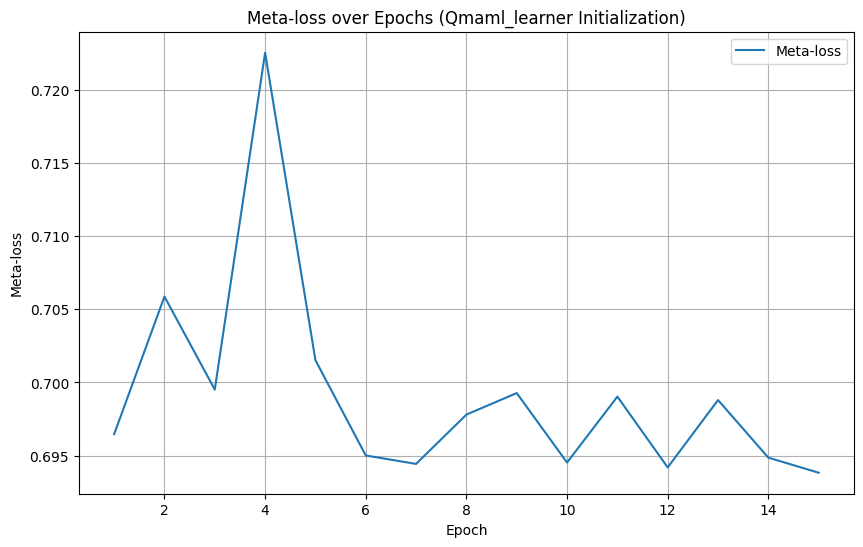

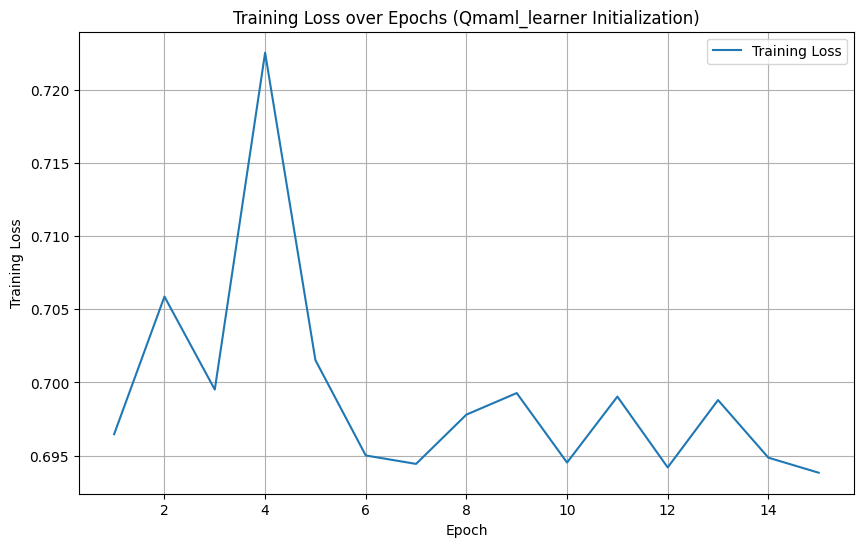

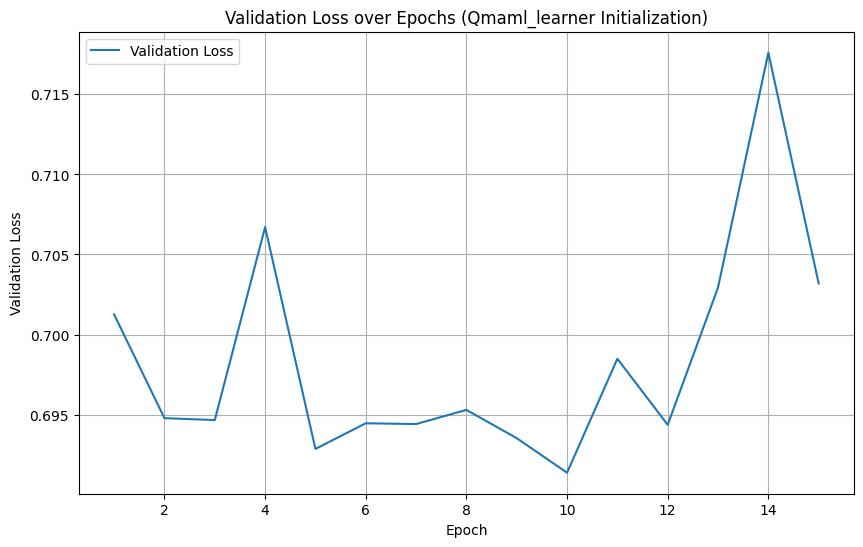

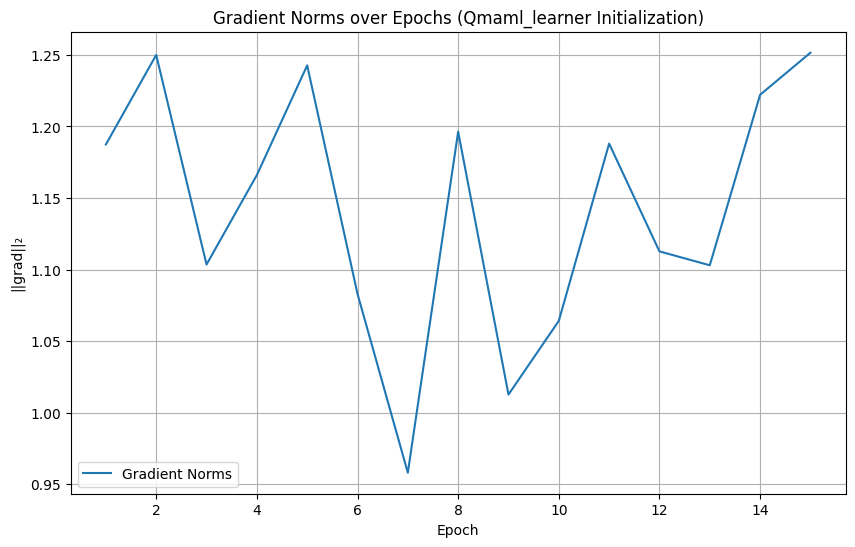

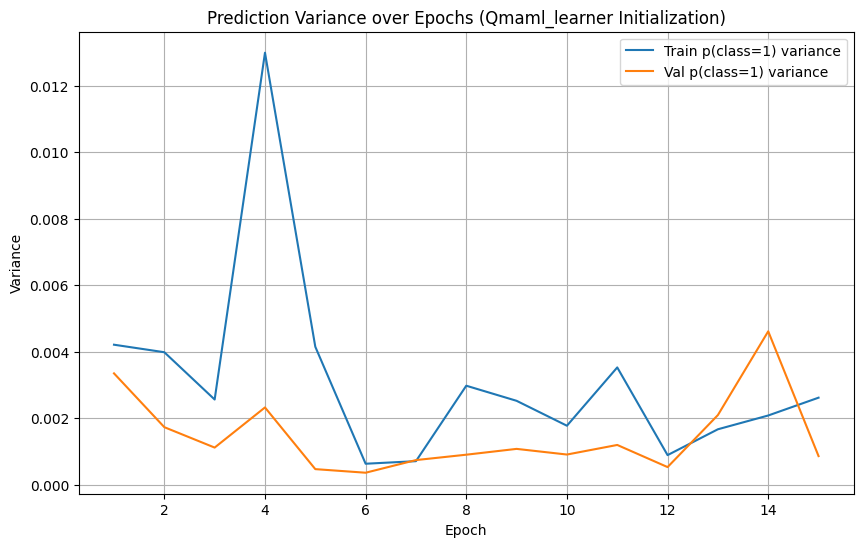

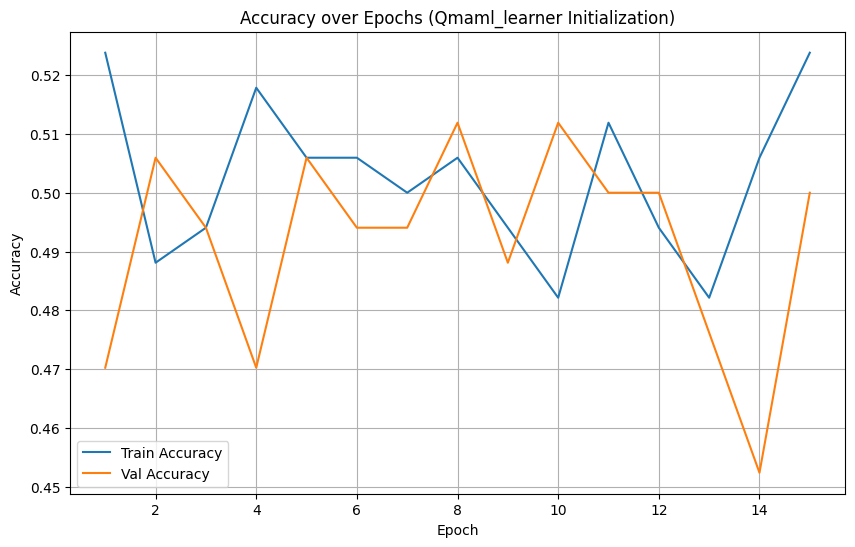


=== Testing initialization: zero ===
[PQC] Using lightning.qubit + adjoint
[Probe 7A] zero  grad||pqc.weights: 0.007131058142586482  grad||pqc.fc.weight: 0.3651289641857147
[Probe 7A]  grad||feature.weight: 74.68498992919922
[Probe 7B] zero  ||Δθ|| = 0.010065161861101915
[Probe 7C] zero  feat mean: 4.308560371398926  feat std: 72.93231201171875
[Probe 7D] zero  p1[min,mean,max]: 0.5341055393218994 0.5341055393218994 0.5341055393218994
[Reptile] Epoch 1/15 | Meta-loss 0.7005 | Val Loss 0.6968 | Train Acc 0.5000 | Val Acc 0.5238 | Train p-var 0.0017 | Val p-var 0.0015
[Reptile] Epoch 2/15 | Meta-loss 0.7041 | Val Loss 0.6900 | Train Acc 0.4940 | Val Acc 0.5000 | Train p-var 0.0019 | Val p-var 0.0015
[Reptile] Epoch 3/15 | Meta-loss 0.6997 | Val Loss 0.6964 | Train Acc 0.4940 | Val Acc 0.5357 | Train p-var 0.0015 | Val p-var 0.0015
[Reptile] Epoch 4/15 | Meta-loss 0.6960 | Val Loss 0.6912 | Train Acc 0.5179 | Val Acc 0.5298 | Train p-var 0.0015 | Val p-var 0.0020
[Reptile] Epoch 5/15 | M

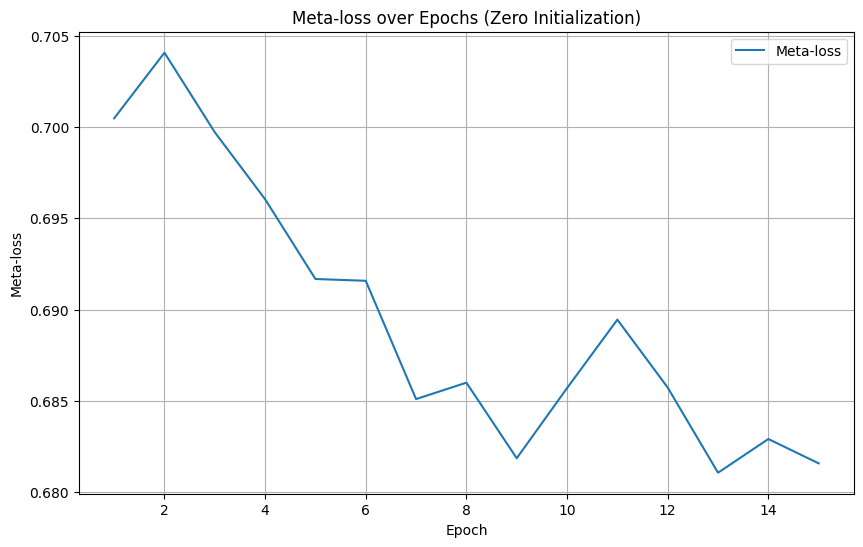

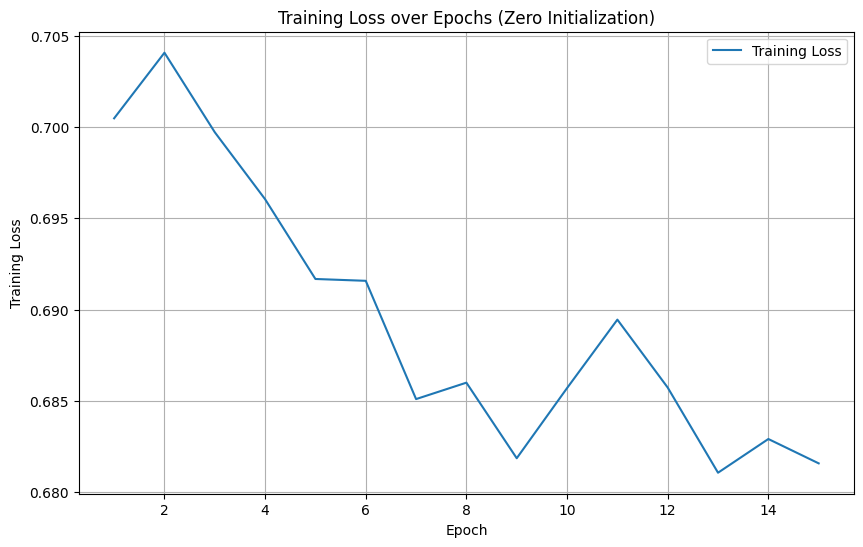

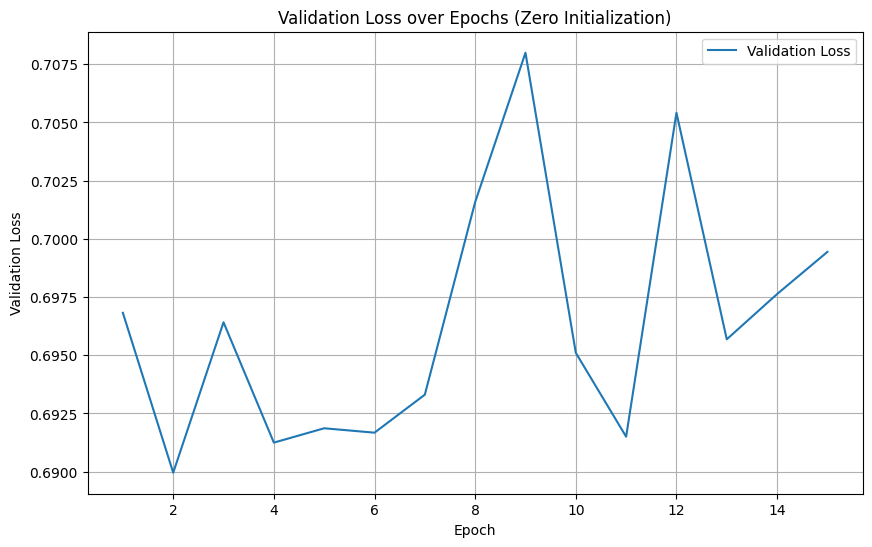

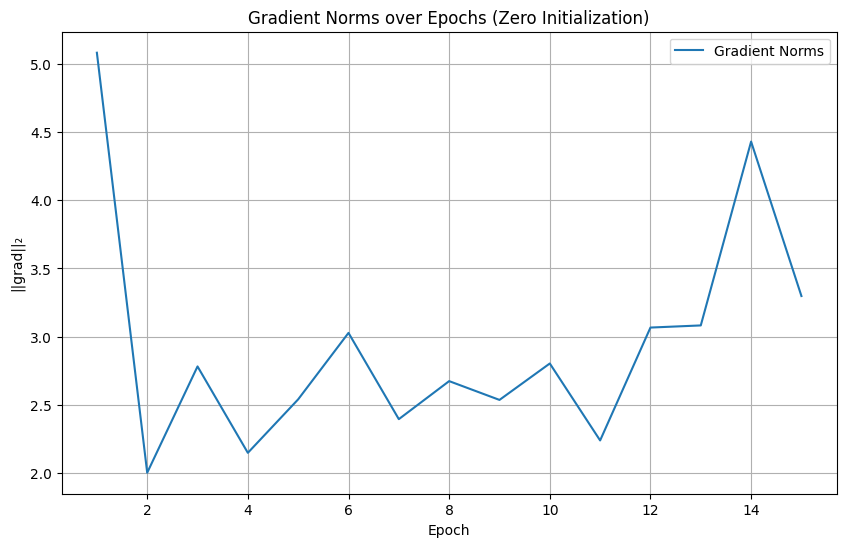

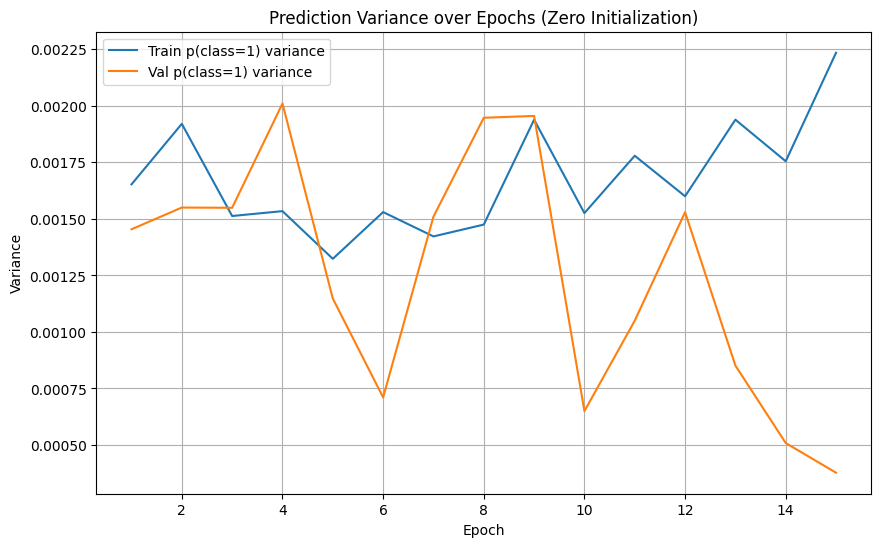

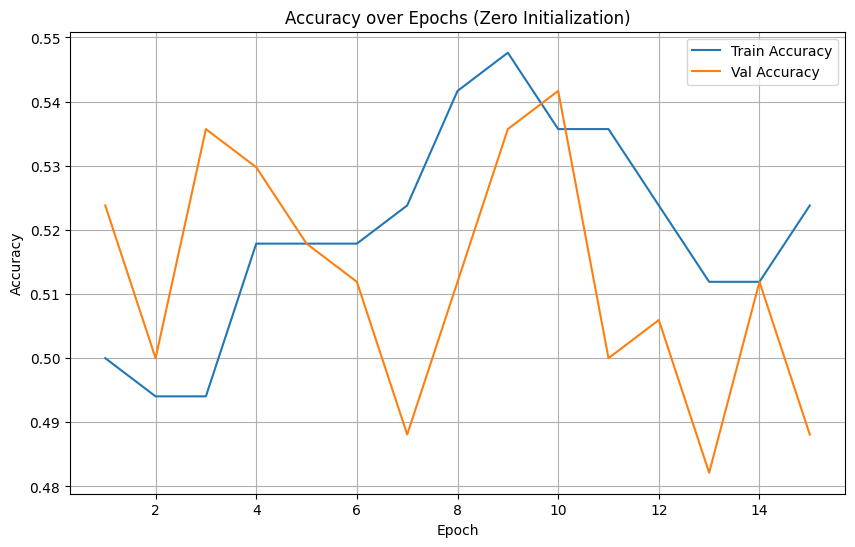


=== Testing initialization: pi ===
[PQC] Using lightning.qubit + adjoint
[Probe 7A] pi  grad||pqc.weights: 0.025332127930195594  grad||pqc.fc.weight: 0.4788007140159607
[Probe 7A]  grad||feature.weight: 267.1147766113281
[Probe 7B] pi  ||Δθ|| = 0.013575769960650148
[Probe 7C] pi  feat mean: 1.7711189985275269  feat std: 72.96218872070312
[Probe 7D] pi  p1[min,mean,max]: 0.22818109393119812 0.22818109393119812 0.22818109393119812
[Reptile] Epoch 1/15 | Meta-loss 0.7400 | Val Loss 0.6731 | Train Acc 0.4881 | Val Acc 0.5298 | Train p-var 0.0031 | Val p-var 0.0034
[Reptile] Epoch 2/15 | Meta-loss 0.7196 | Val Loss 0.6740 | Train Acc 0.4881 | Val Acc 0.5298 | Train p-var 0.0027 | Val p-var 0.0030
[Reptile] Epoch 3/15 | Meta-loss 0.6989 | Val Loss 0.6774 | Train Acc 0.5000 | Val Acc 0.5298 | Train p-var 0.0015 | Val p-var 0.0031
[Reptile] Epoch 4/15 | Meta-loss 0.6913 | Val Loss 0.6804 | Train Acc 0.5119 | Val Acc 0.5000 | Train p-var 0.0018 | Val p-var 0.0033
[Reptile] Epoch 5/15 | Meta-lo

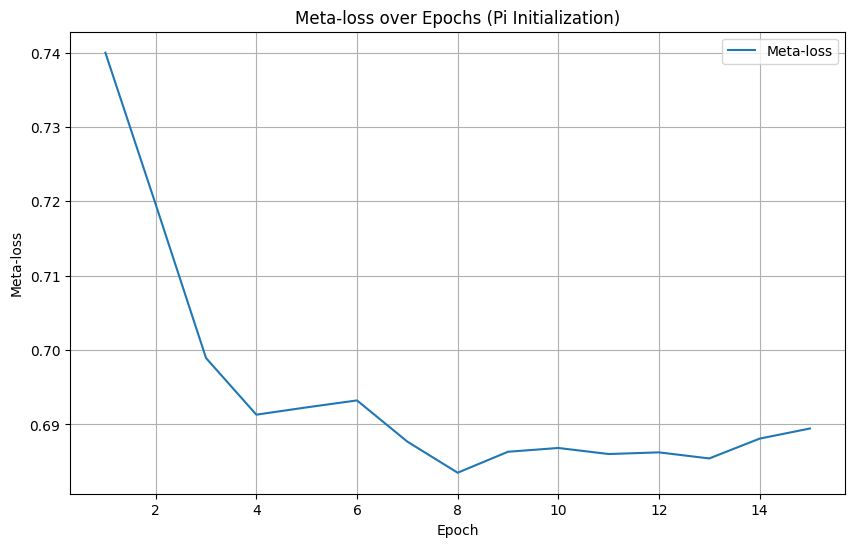

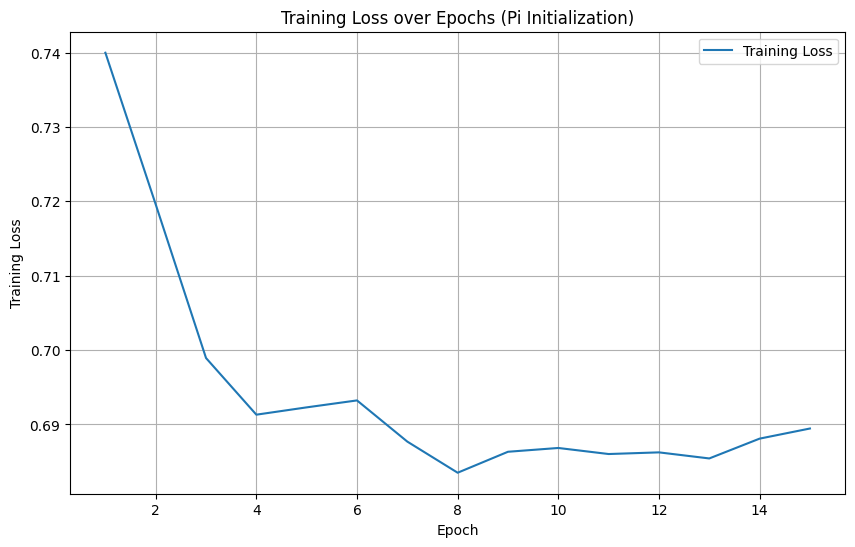

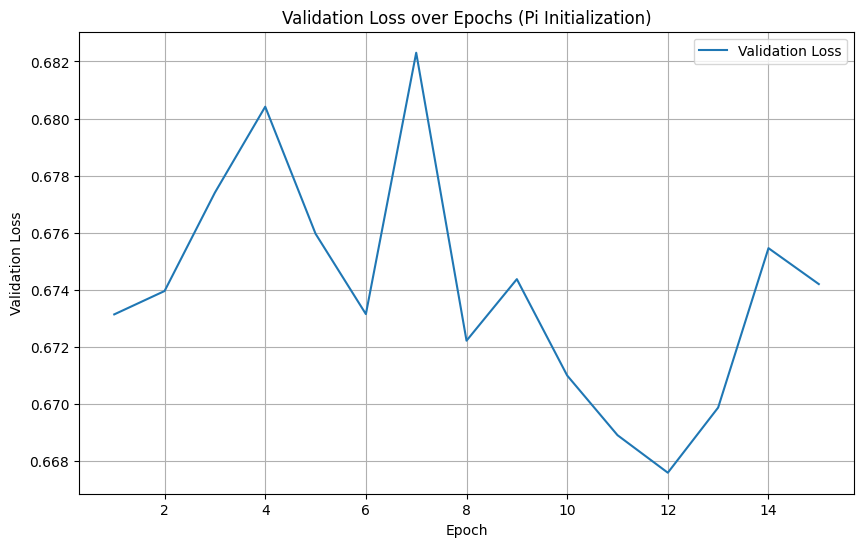

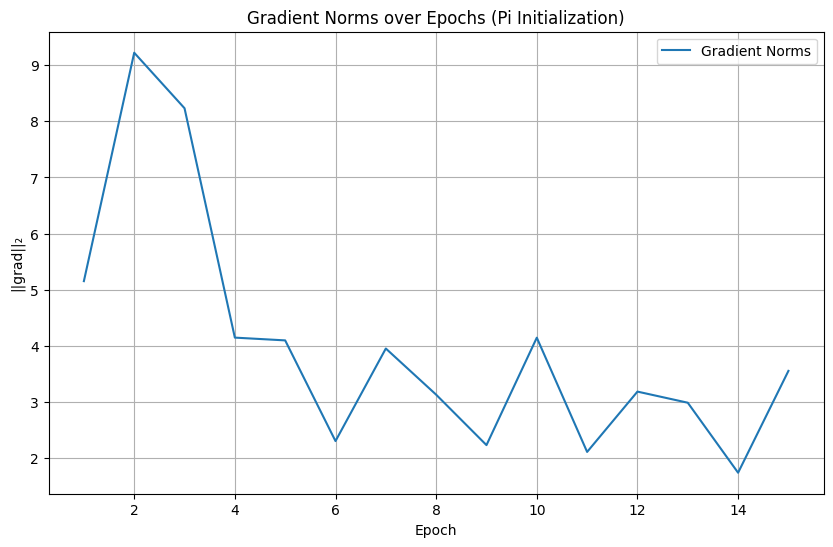

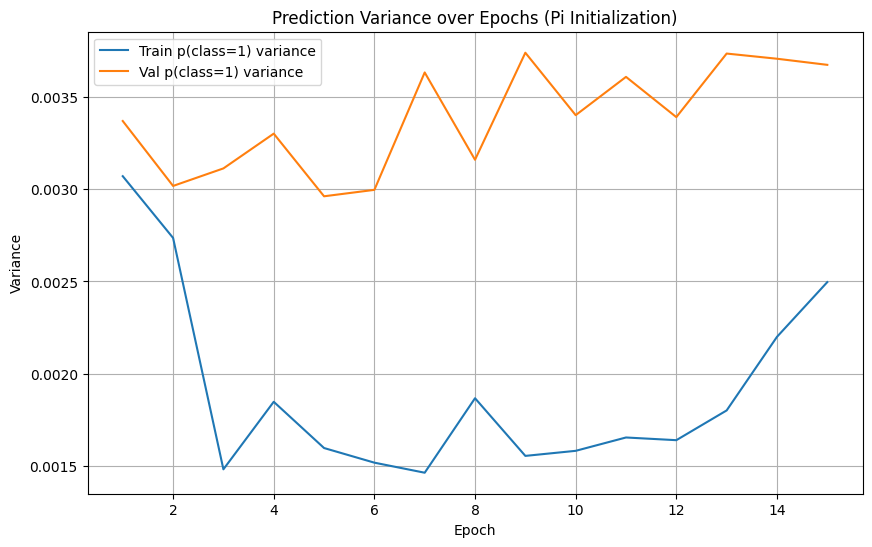

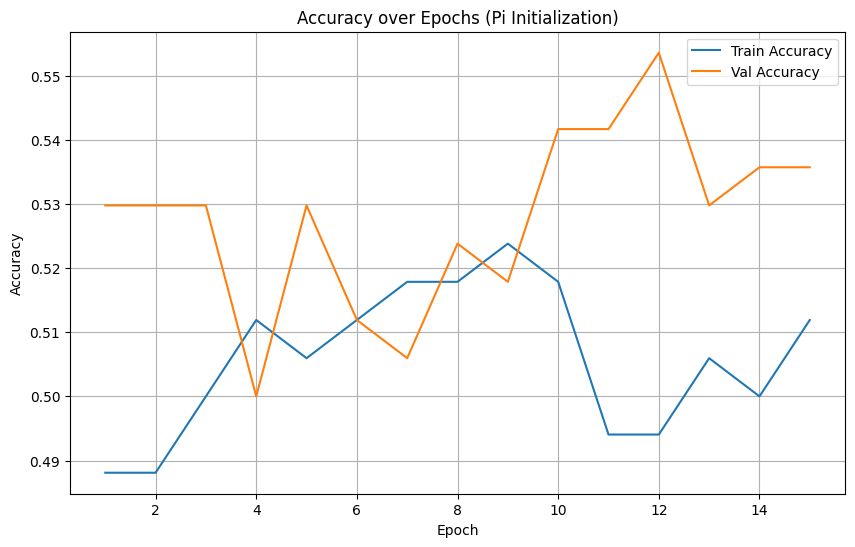


=== Testing initialization: uniform ===
[PQC] Using lightning.qubit + adjoint
[Probe 7A] uniform  grad||pqc.weights: 0.17501489654125688  grad||pqc.fc.weight: 0.9948218464851379
[Probe 7A]  grad||feature.weight: 949.4844360351562
[Probe 7B] uniform  ||Δθ|| = 0.014101669604342268
[Probe 7C] uniform  feat mean: 5.108163833618164  feat std: 73.01344299316406
[Probe 7D] uniform  p1[min,mean,max]: 0.8021453022956848 0.8021453022956848 0.8021453022956848
[Reptile] Epoch 1/15 | Meta-loss 0.7472 | Val Loss 0.6884 | Train Acc 0.5179 | Val Acc 0.5119 | Train p-var 0.0041 | Val p-var 0.0036
[Reptile] Epoch 2/15 | Meta-loss 0.7125 | Val Loss 0.6796 | Train Acc 0.5417 | Val Acc 0.5417 | Train p-var 0.0030 | Val p-var 0.0023
[Reptile] Epoch 3/15 | Meta-loss 0.7036 | Val Loss 0.6810 | Train Acc 0.5179 | Val Acc 0.5476 | Train p-var 0.0021 | Val p-var 0.0018
[Reptile] Epoch 4/15 | Meta-loss 0.6924 | Val Loss 0.6781 | Train Acc 0.5298 | Val Acc 0.5536 | Train p-var 0.0016 | Val p-var 0.0019
[Reptile] 

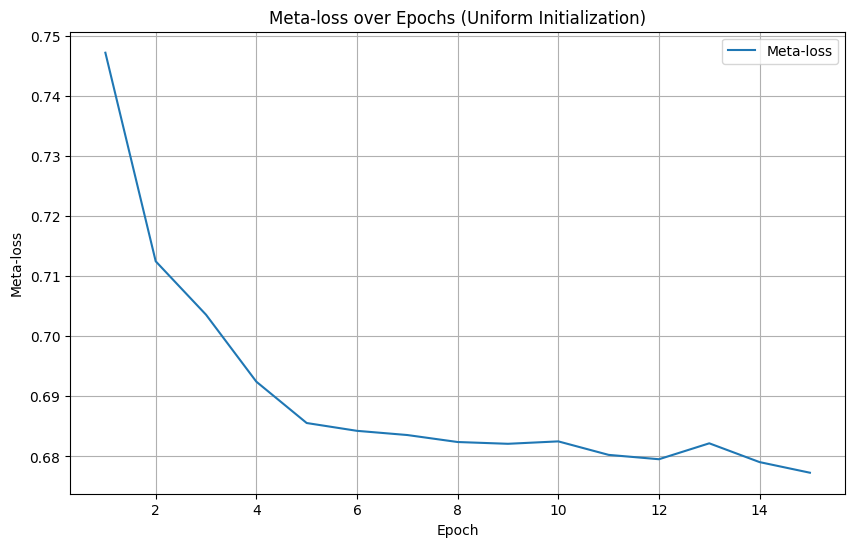

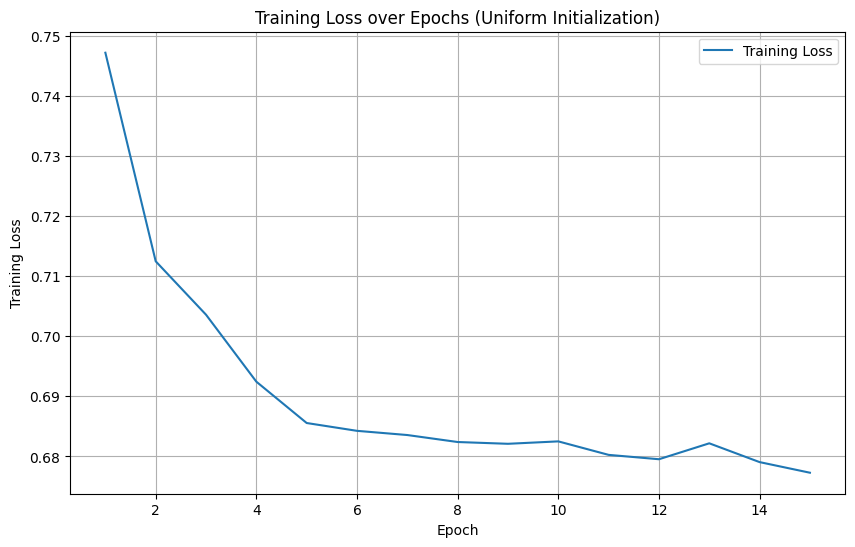

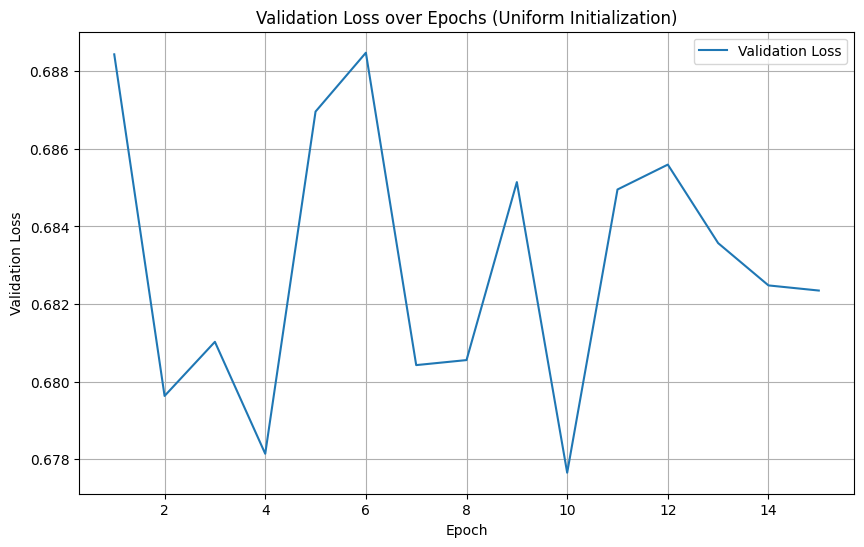

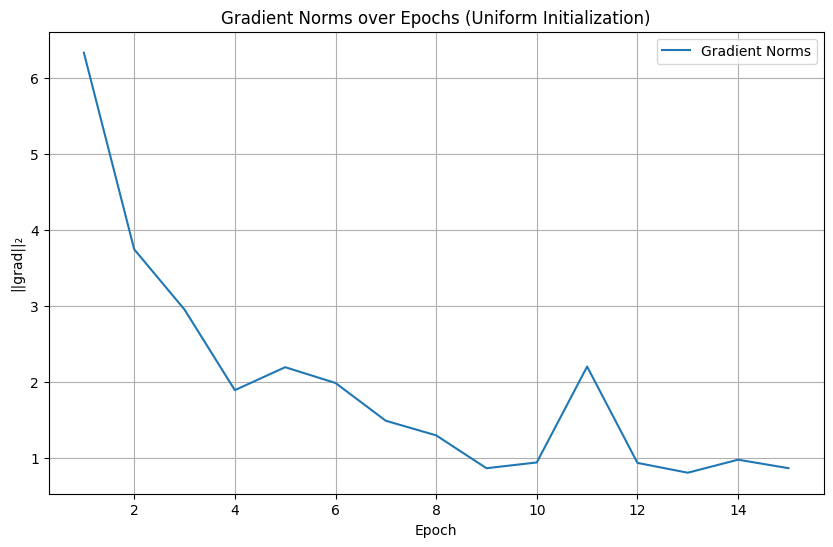

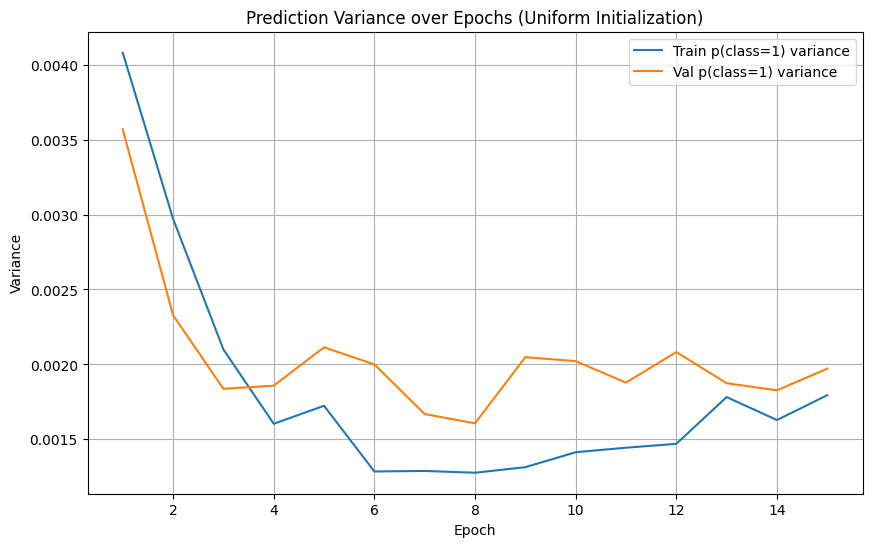

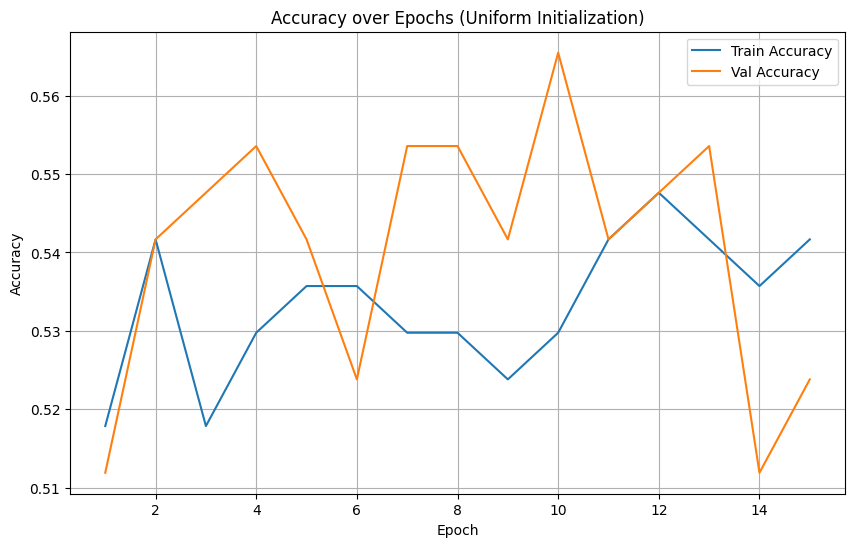


=== Testing initialization: gaussian ===
[PQC] Using lightning.qubit + adjoint
[Probe 7A] gaussian  grad||pqc.weights: 0.04831707113420698  grad||pqc.fc.weight: 0.7848589420318604
[Probe 7A]  grad||feature.weight: 348.9762268066406
[Probe 7B] gaussian  ||Δθ|| = 0.014157422111110006
[Probe 7C] gaussian  feat mean: 1.9891937971115112  feat std: 72.9451675415039
[Probe 7D] gaussian  p1[min,mean,max]: 0.101758673787117 0.101758673787117 0.101758673787117
[Reptile] Epoch 1/15 | Meta-loss 0.8596 | Val Loss 0.6999 | Train Acc 0.5000 | Val Acc 0.5000 | Train p-var 0.0050 | Val p-var 0.0052
[Reptile] Epoch 2/15 | Meta-loss 0.7820 | Val Loss 0.6975 | Train Acc 0.4881 | Val Acc 0.4940 | Train p-var 0.0035 | Val p-var 0.0031
[Reptile] Epoch 3/15 | Meta-loss 0.7378 | Val Loss 0.6952 | Train Acc 0.4881 | Val Acc 0.5060 | Train p-var 0.0023 | Val p-var 0.0027
[Reptile] Epoch 4/15 | Meta-loss 0.7190 | Val Loss 0.6936 | Train Acc 0.4881 | Val Acc 0.5060 | Train p-var 0.0018 | Val p-var 0.0019
[Reptile

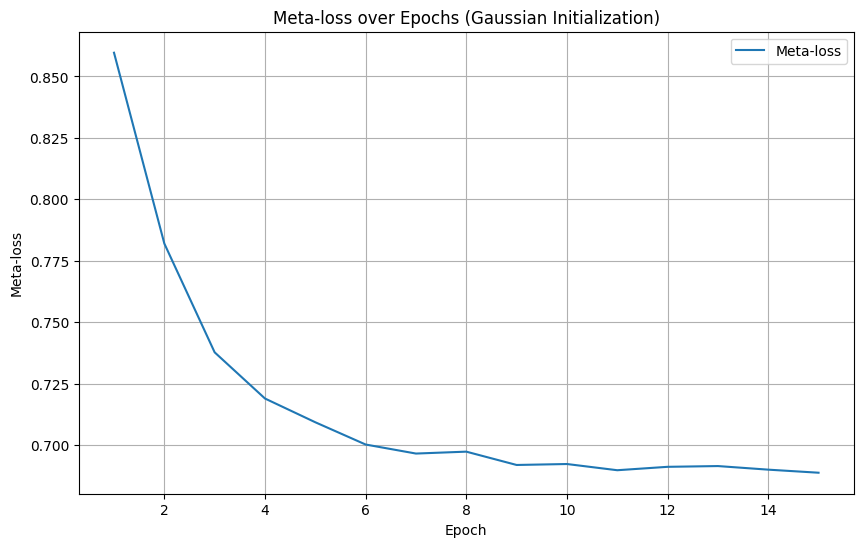

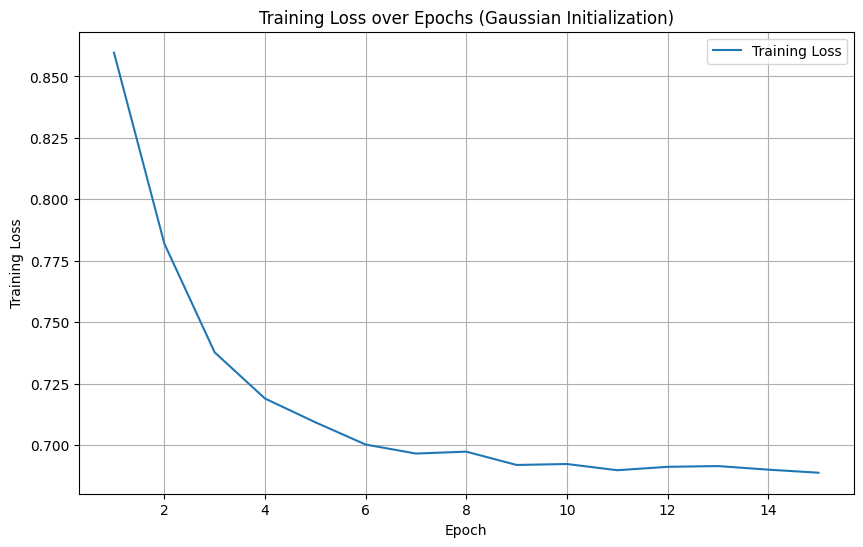

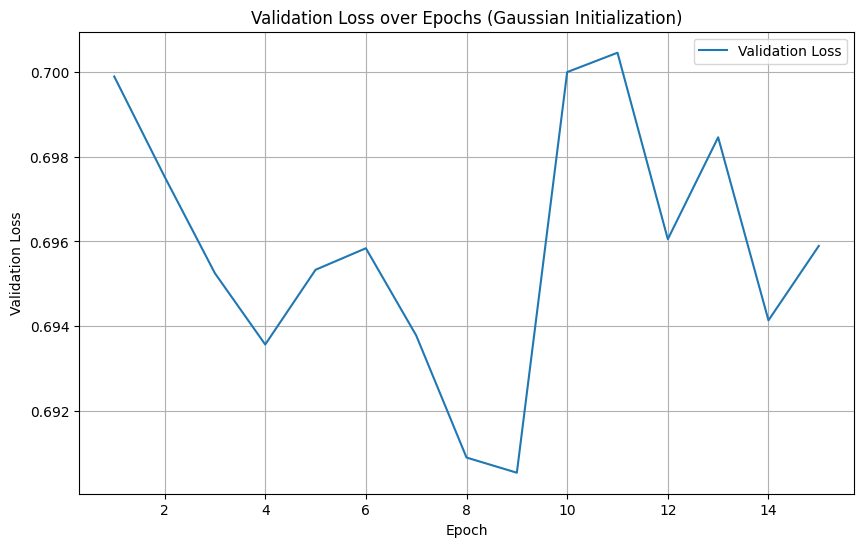

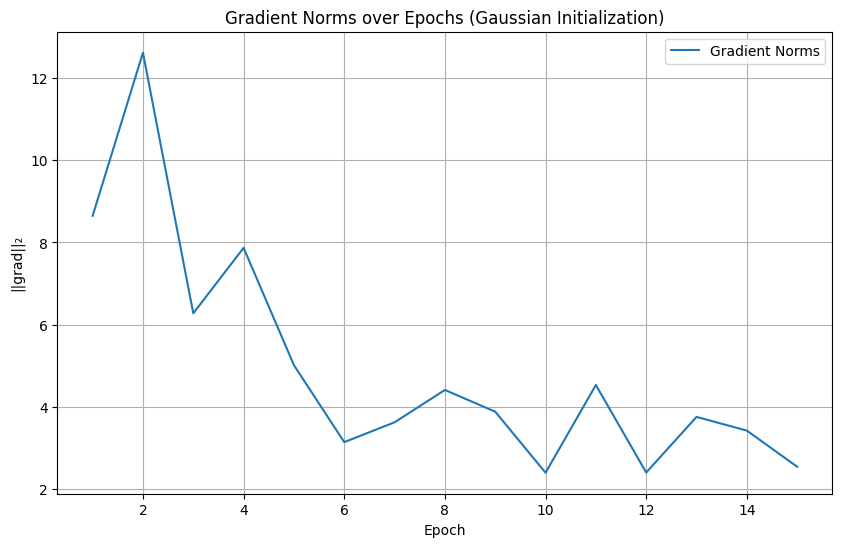

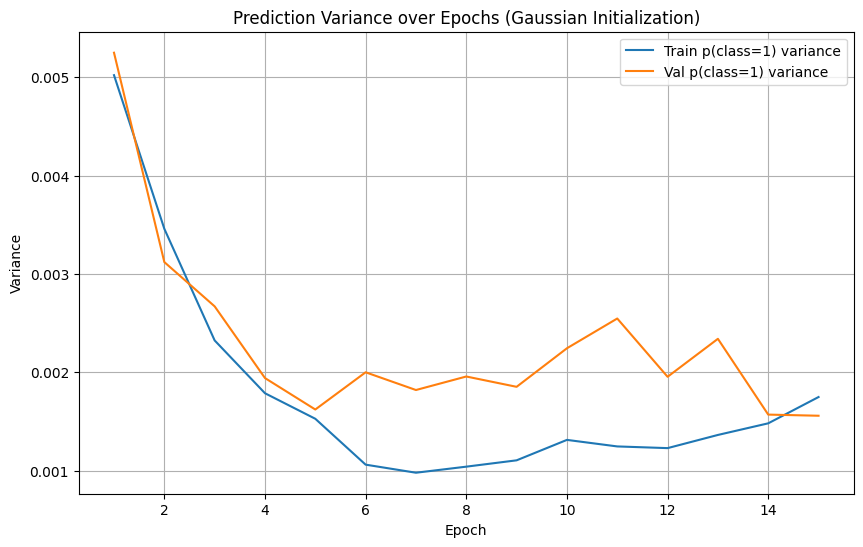

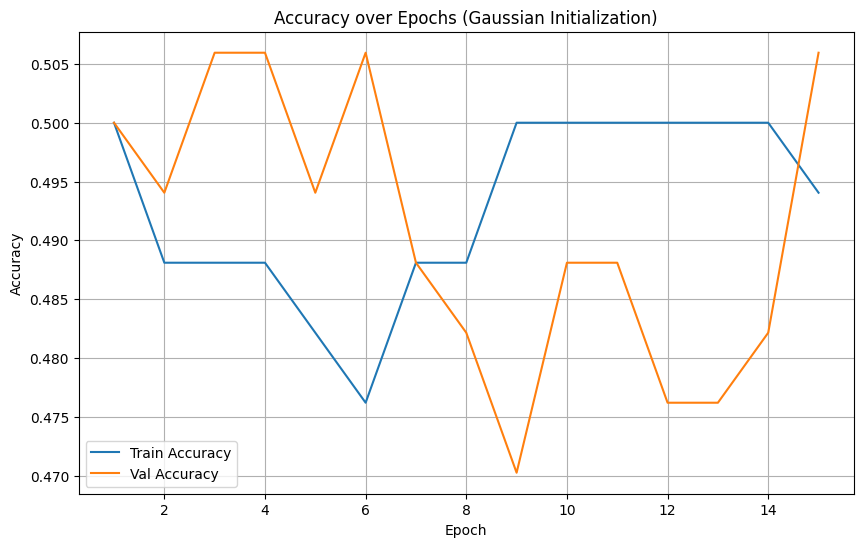

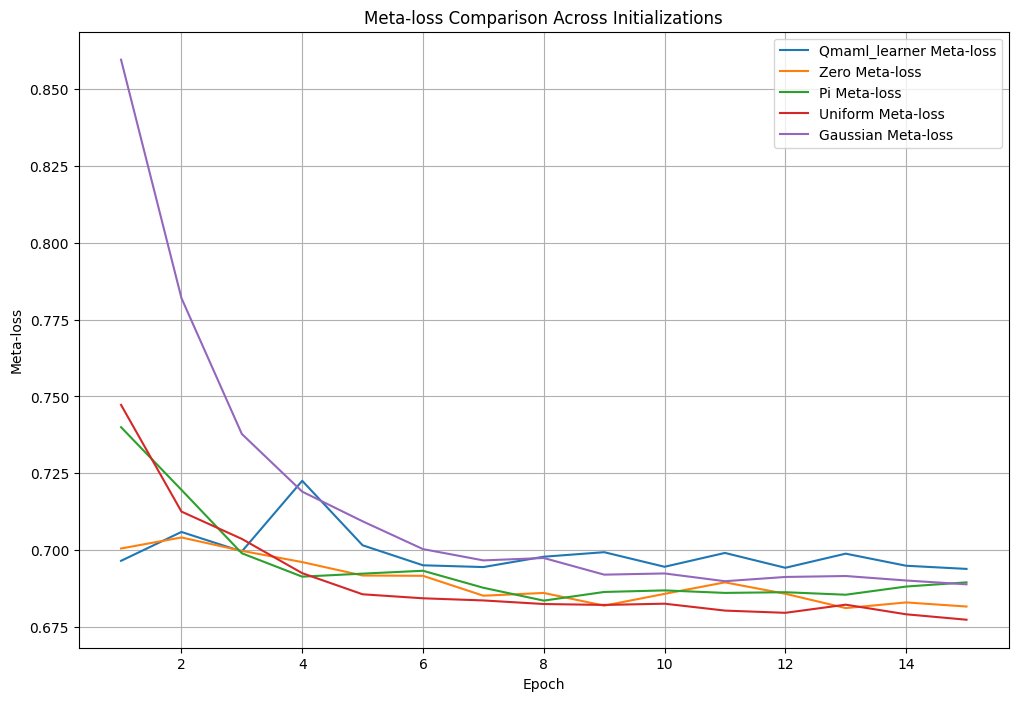

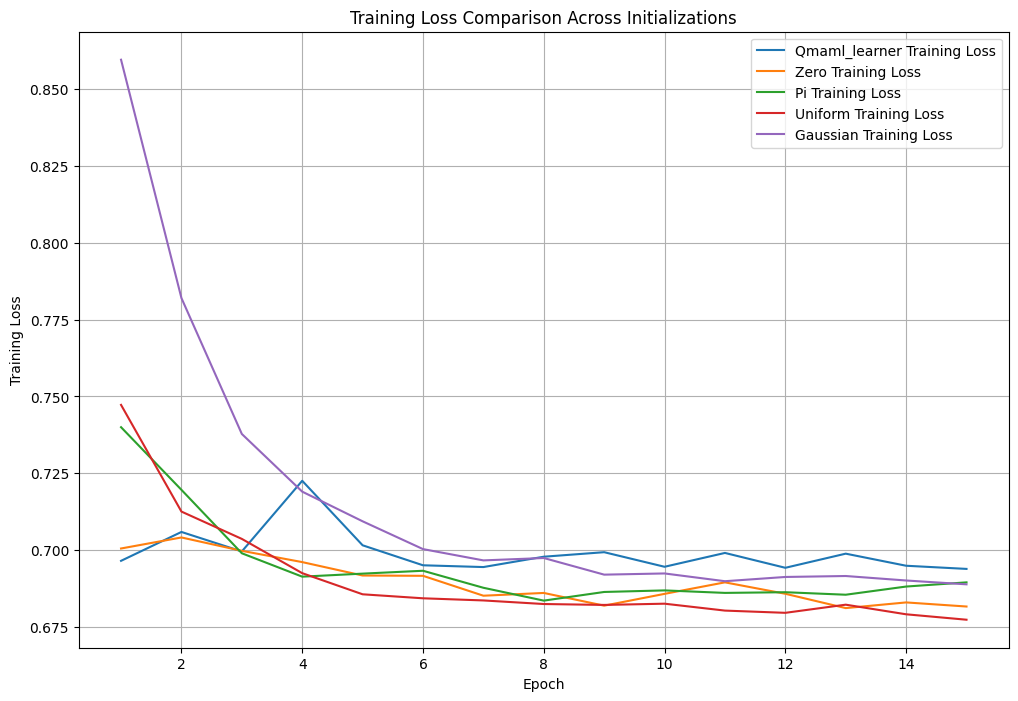

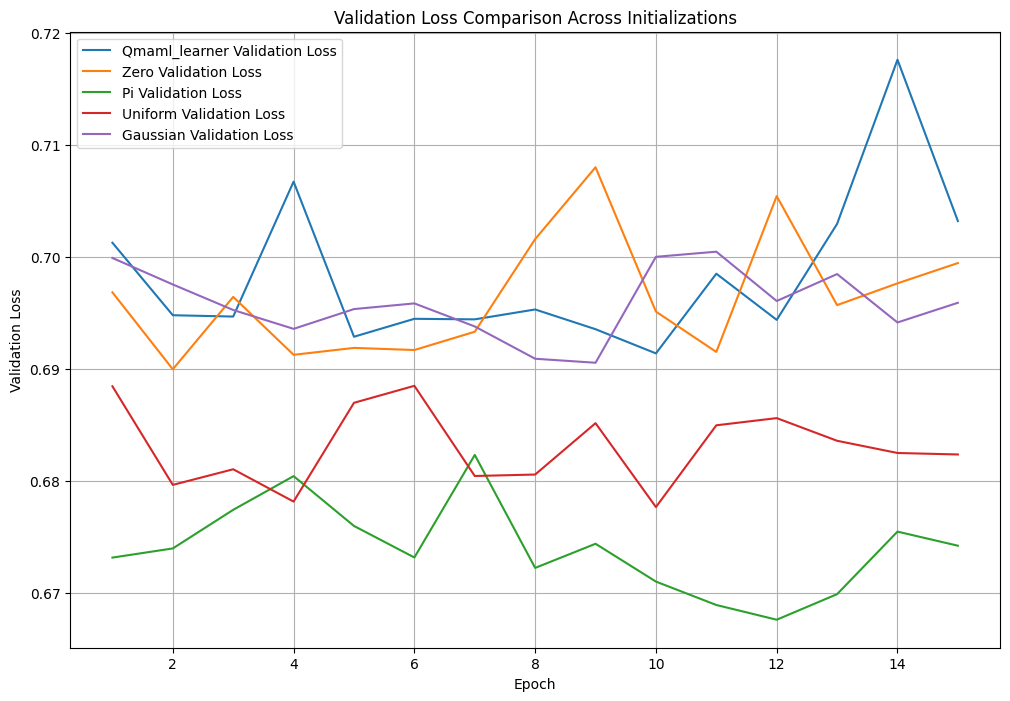

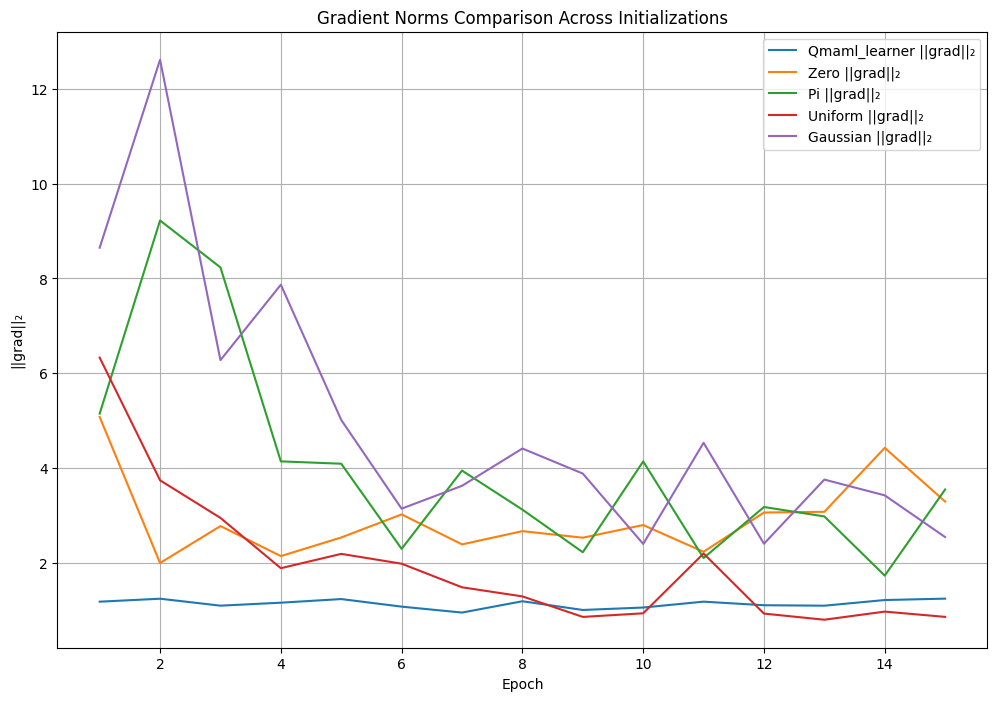

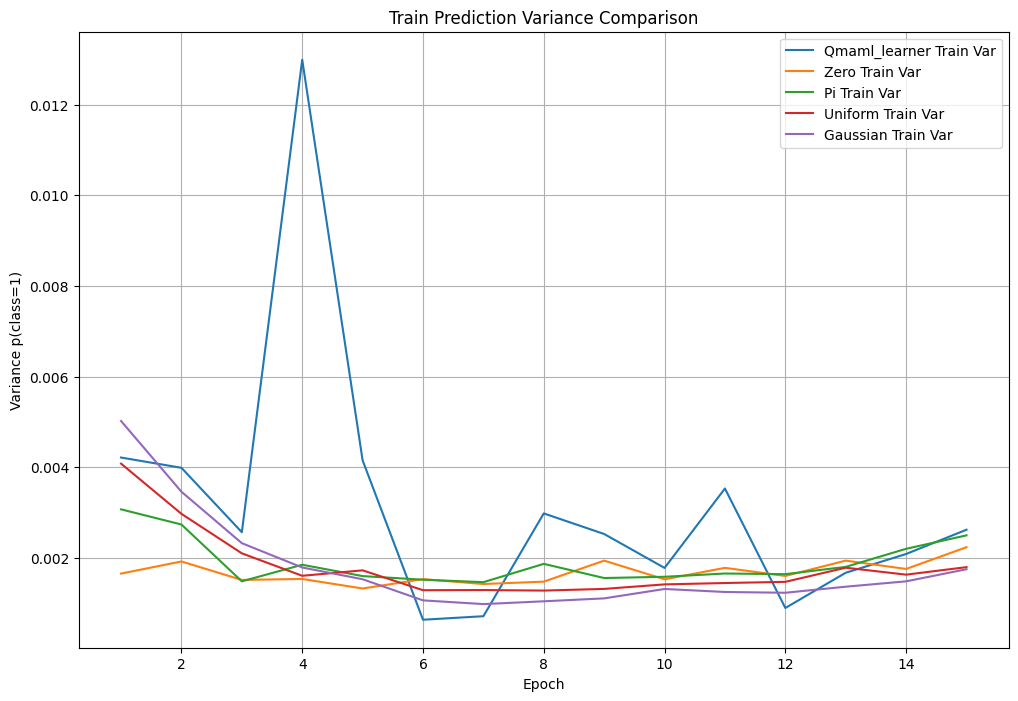

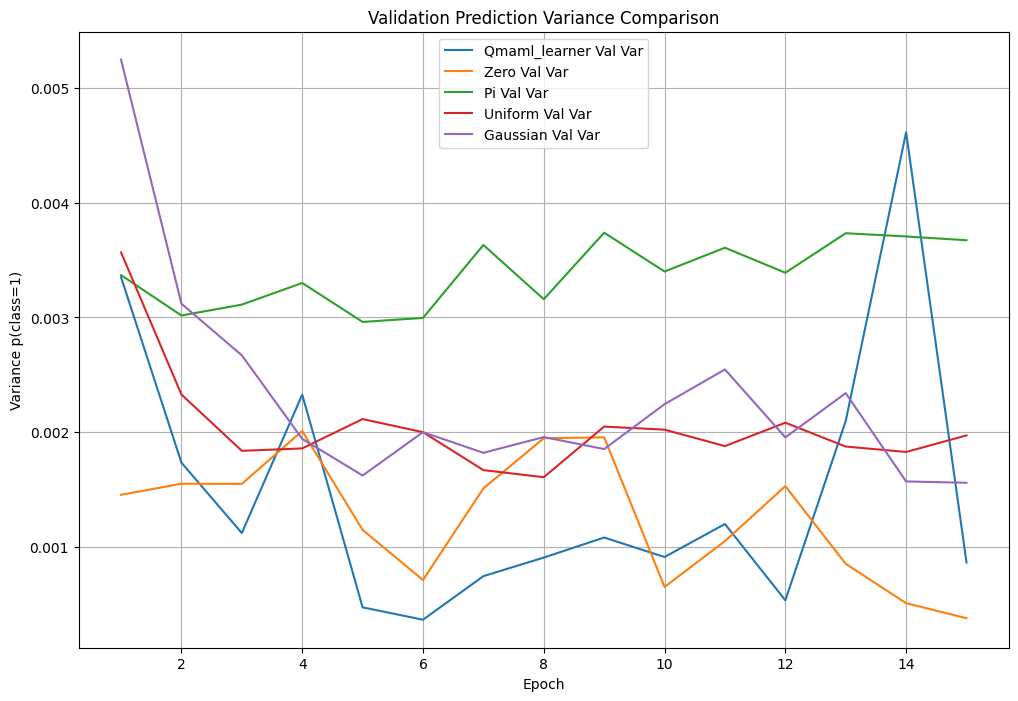

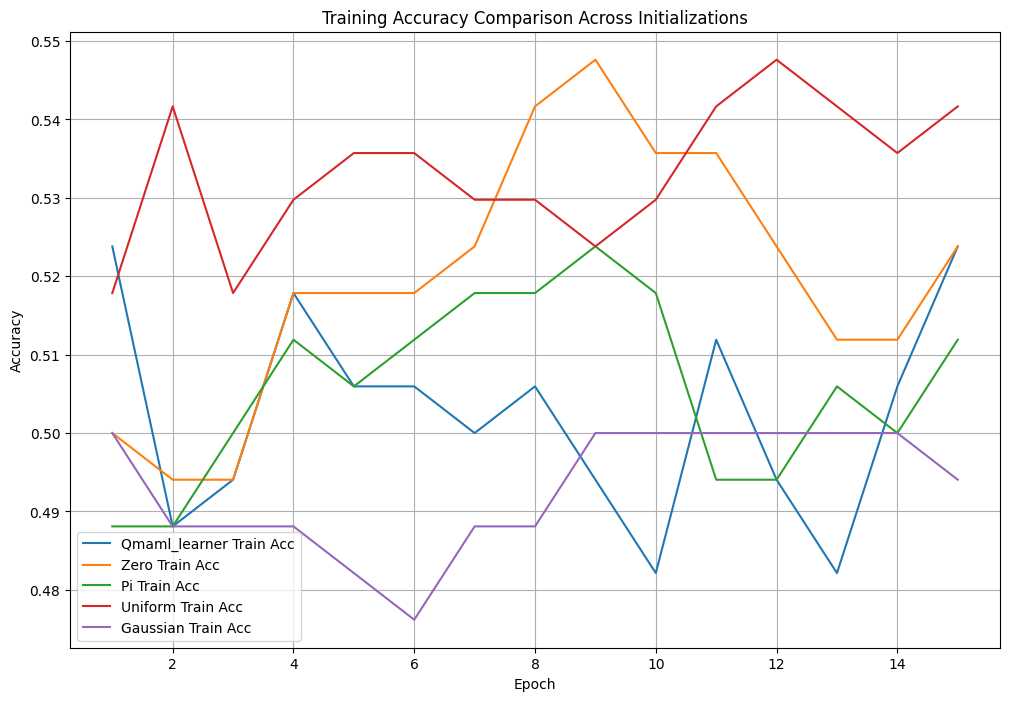

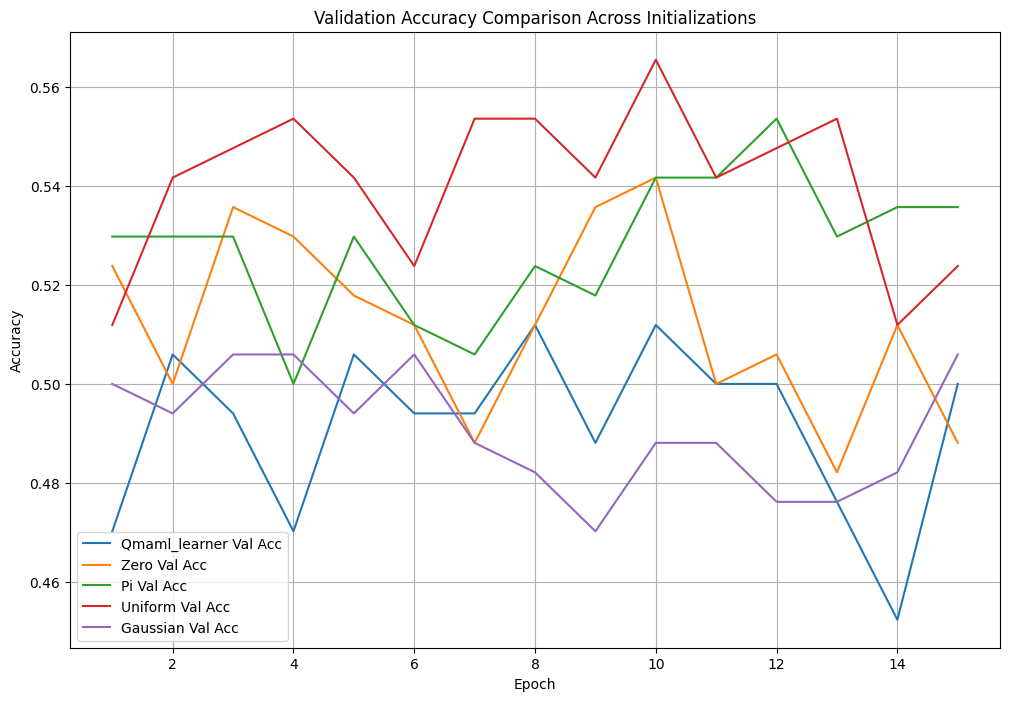

In [ ]:
# --- Cell 16: Running (PCA feature extractor version) ---
initialization_types = ["qmaml_learner", "zero", "pi", "uniform", "gaussian"]
results: Dict[str, Dict[str, List[float]]] = {}

for init_type in initialization_types:
    print(f"\n=== Testing initialization: {init_type} ===")
    torch.manual_seed(42); np.random.seed(42)

    # 1) Instantiate + FIT the PCA feature extractor (must be fit before use)
    feature_extractor = PCAFeatureExtractor(
        output_dim=config.CNN_OUTPUT_DIM,
        num_qubits=config.NUM_QUBITS,
        method="randomized"
    )

    feature_extractor.fit(train_dataset, max_samples=6000, batch_size=1000, whiten=True)

    freeze_bn(feature_extractor)

    # 3) PQC with bounded angles for stability
    pqc_init = "zero" if init_type == "qmaml_learner" else init_type
    pqc_model = PQCModel(
        config.NUM_QUBITS,
        config.Q_DEPTH,
        init_type=pqc_init,
        bound_angles=True,
        verbose=True,
    )

    # 4) Hybrid model (feature extractor + PQC)
    hybrid_model = HybridModel(feature_extractor, pqc_model)

    # -------- Sanity probes (run once per init_type) --------
    _sx = meta_tasks[0]["support_X"][:8]
    _sy = meta_tasks[0]["support_y"][:8]
    _qx = meta_tasks[0]["query_X"]

    # ---- 7A) Gradient flow to PQC angles and PQC head ----
    for p in hybrid_model.parameters():
        if p.grad is not None:
            p.grad.zero_()
    _logits = hybrid_model(_sx)
    _loss = nn.CrossEntropyLoss()(_logits, _sy)
    _loss.backward()

    def _gnorm(p):
        return None if (p.grad is None) else float(p.grad.norm().item())

    print("[Probe 7A]", init_type,
          " grad||pqc.weights:", _gnorm(pqc_model.weights),
          " grad||pqc.fc.weight:", _gnorm(pqc_model.fc.weight))

    # Try to also print a feature-extractor weight grad (works for PCA or CNN)
    try:
        if hasattr(feature_extractor, "to_angles"):
            _feat_w = feature_extractor.to_angles.weight
        elif hasattr(feature_extractor, "model"):
            _feat_w = feature_extractor.model.fc[0].weight  # CNN fallback
        else:
            _feat_w = None
        if _feat_w is not None:
            print("[Probe 7A]  grad||feature.weight:", _gnorm(_feat_w))
    except Exception:
        pass  # fine if structure differs

    # ---- 7B) Inner loop movement (quick check) ----
    def _flat_params(m):
        return torch.cat([p.detach().flatten().cpu() for p in m.parameters() if p.requires_grad])

    _before = _flat_params(hybrid_model)
    _adapted, _ = inner_loop_adaptation(
        HybridModel(feature_extractor, pqc_model),
        meta_tasks[0]["support_X"], meta_tasks[0]["support_y"],
        inner_steps=2, inner_lr=0.01
    )
    _after = _flat_params(hybrid_model)
    _dtheta = torch.norm(_after - _before).item()
    print("[Probe 7B]", init_type, " ||Δθ|| =", _dtheta)

    # ---- 7C) Feature stats (from PCA features) ----
    with torch.no_grad():
        _f = feature_extractor(meta_tasks[0]["support_X"])
    print("[Probe 7C]", init_type, " feat mean:", _f.mean().item(), " feat std:", _f.std().item())

    # ---- 7D) Prediction distribution on a query mini-batch ----
    with torch.no_grad():
        _p = torch.softmax(hybrid_model(_qx[:16]), dim=1)[:, 1]
    print("[Probe 7D]", init_type, " p1[min,mean,max]:",
          _p.min().item(), _p.mean().item(), _p.max().item())

    # -------- Train for this init_type --------
    if init_type == "qmaml_learner":
        warmup_pqc_head(hybrid_model, meta_tasks, steps=100, lr=1e-2)
        training_results = outer_loop_qmaml(
            hybrid_model,
            meta_tasks,
            test_meta_tasks,
            config.OUTER_LR,
            config.EVAL_METRICS,
            ckpt_name="best_qmaml_learner.pth",
        )
    else:
        training_results = outer_loop_meta_update(
            hybrid_model,
            meta_tasks,
            test_meta_tasks,
            config.OUTER_LR,
            config.EVAL_METRICS,
            ckpt_name=f"best_{init_type}.pth",
        )

    results[init_type] = training_results
    plot_training_results(training_results, init_type)

# Combined comparison plots
plot_comparison(results)
